# 1. Setup and Import Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os, csv
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import deque
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 2. Download 25+ Years of Data for SPY, QQQ, DIA

In [23]:
tickers = ['SPY', 'QQQ', 'DIA', '^VIX']
start_date = "2000-01-01"
end_date = "2025-05-31"

data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Check data

In [24]:
for ticker in data:
    print(f"=== {ticker} - First 5 rows ===")
    display(data[ticker].head())
    
    print(f"=== {ticker} - Last 5 rows ===")
    display(data[ticker].tail())

=== SPY - First 5 rows ===


Price           Close       High        Low       Open    Volume
Ticker            SPY        SPY        SPY        SPY       SPY
Date                                                            
2000-01-03  92.414925  94.202063  91.422070  94.202063   8164300
2000-01-04  88.800919  91.541197  88.731419  91.203627   8089800
2000-01-05  88.959793  89.932791  87.212369  88.920079  12177900
2000-01-06  87.530075  89.912926  87.530075  88.721501   6227200
2000-01-07  92.613518  92.613518  88.999525  89.158382   8066500

=== SPY - Last 5 rows ===


Price            Close        High         Low        Open    Volume
Ticker             SPY         SPY         SPY         SPY       SPY
Date                                                                
2025-05-23  579.109985  581.809998  575.599976  575.979980  76029000
2025-05-27  591.150024  591.309998  578.429993  586.070007  72588500
2025-05-28  587.729980  592.770020  586.989990  591.559998  68445500
2025-05-29  590.049988  593.200012  586.070007  593.059998  69973300
2025-05-30  589.390015  591.130005  583.239990  588.929993  90601200

=== QQQ - First 5 rows ===


Price           Close       High        Low       Open    Volume
Ticker            QQQ        QQQ        QQQ        QQQ       QQQ
Date                                                            
2000-01-03  80.314285  81.532774  76.923709  81.532774  36345200
2000-01-04  74.804604  79.254736  74.539715  77.983269  33786600
2000-01-05  72.897423  75.970134  71.414045  74.168889  42496600
2000-01-06  67.890991  74.592677  67.599614  73.639077  37134800
2000-01-07  76.288002  76.288002  69.930669  70.301513  28138200

=== QQQ - Last 5 rows ===


Price            Close        High         Low        Open    Volume
Ticker             QQQ         QQQ         QQQ         QQQ       QQQ
Date                                                                
2025-05-23  509.239990  511.839996  505.579987  506.179993  58368100
2025-05-27  521.219971  521.710022  514.590027  516.150024  47226300
2025-05-28  518.909973  523.679993  518.390015  522.179993  46637200
2025-05-29  519.929993  526.479980  517.320007  526.330017  58513300
2025-05-30  519.109985  520.679993  511.929993  519.440002  67662800

=== DIA - First 5 rows ===


Price           Close       High        Low       Open   Volume
Ticker            DIA        DIA        DIA        DIA      DIA
Date                                                           
2000-01-03  65.827835  67.295912  65.537845  67.295912  1278800
2000-01-04  63.661968  65.519720  63.661968  65.120983  1535700
2000-01-05  64.486633  65.175361  63.236049  63.797906  2007000
2000-01-06  64.812813  65.637472  64.486574  64.613445  2639500
2000-01-07  66.987862  67.024110  65.664779  65.719152  3767400

=== DIA - Last 5 rows ===


Price            Close        High         Low        Open   Volume
Ticker             DIA         DIA         DIA         DIA      DIA
Date                                                               
2025-05-23  416.329987  418.170013  413.829987  413.940002  3117800
2025-05-27  423.850006  423.859985  419.190002  420.700012  3126600
2025-05-28  421.420013  424.829987  420.739990  423.730011  1790900
2025-05-29  422.459991  423.019989  418.579987  422.459991  2751400
2025-05-30  422.850006  424.269989  419.510010  422.160004  2957500

=== ^VIX - First 5 rows ===


Price           Close       High        Low       Open Volume
Ticker           ^VIX       ^VIX       ^VIX       ^VIX   ^VIX
Date                                                         
2000-01-03  24.209999  26.150000  23.980000  24.360001      0
2000-01-04  27.010000  27.180000  24.799999  24.940001      0
2000-01-05  26.410000  29.000000  25.850000  27.980000      0
2000-01-06  25.730000  26.709999  24.700001  26.680000      0
2000-01-07  21.719999  25.170000  21.719999  25.139999      0

=== ^VIX - Last 5 rows ===


Price           Close       High        Low       Open Volume
Ticker           ^VIX       ^VIX       ^VIX       ^VIX   ^VIX
Date                                                         
2025-05-23  22.290001  25.530001  19.830000  20.139999      0
2025-05-27  18.959999  21.010000  18.950001  20.629999      0
2025-05-28  19.309999  19.430000  18.680000  19.209999      0
2025-05-29  19.180000  20.200001  18.110001  18.250000      0
2025-05-30  18.570000  20.549999  18.570000  19.610001      0

# 3. Calculate Technical Indicators (RSI, MACD, TSI, etc.)

In [25]:
import ta

def add_indicators(df):
    df = df.copy()

    close = df['Close'].squeeze()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=close, window=14).rsi()

    # MACD components
    macd = ta.trend.MACD(close=close)
    df['MACD_Line'] = macd.macd()
    df['Signal_Line'] = macd.macd_signal()
    df['MACD_Histogram'] = macd.macd_diff()

    # EMAs for reference
    df['EMA_3'] = ta.trend.EMAIndicator(close=close, window=3).ema_indicator()
    df['EMA_5'] = ta.trend.EMAIndicator(close=close, window=5).ema_indicator()

    return df

## Add custom indicator TSI (Trend Strength Index) from TradingView

In [26]:
def trend_strength_index(close_prices, window=14):
    tsi_values = []
    close_array = close_prices.squeeze().astype(float).values  # Ensure 1D array

    for i in range(len(close_array)):
        if i + 1 < window:
            tsi_values.append(np.nan)
        else:
            price_window = close_array[i + 1 - window: i + 1]  # include index i
            index_window = np.arange(window)
            r, _ = pearsonr(index_window, price_window)
            tsi_values.append(r)

    return pd.Series(tsi_values, index=close_prices.index)

## Apply TSI to each dataset (SPY, QQQ, DIA)

In [27]:
for ticker in ['SPY', 'QQQ', 'DIA']:
    df = data[ticker]
    df = add_indicators(df)
    df['TSI'] = trend_strength_index(df['Close'], window=14)
    data[ticker] = df

## Add VIX values to each dataset (SPY, QQQ, DIA)

In [28]:
# Ensure VIX is aligned by date and rename the close column for clarity
vix_data = data['^VIX'][['Close']].rename(columns={'Close': 'VIX'})

for ticker in ['SPY', 'QQQ', 'DIA']:
    df = data[ticker]

    # Merge VIX values using the index (which should be the date)
    df = df.merge(vix_data, left_index=True, right_index=True, how='left')

    # Store the updated DataFrame back into your dictionary
    data[ticker] = df

## Add Next Day's Return Column

In [29]:
for ticker in ['SPY', 'QQQ', 'DIA']:
    
    df = data[ticker]
    df['Return'] = (df['Close'].shift(-1) - df['Close']) / df['Close']
    df.dropna(inplace=True)
    data[ticker] = df

In [30]:
for ticker in data:
    print(f"=== {ticker} - First 5 rows ===")
    display(data[ticker].head())
    
    print(f"=== {ticker} - Last 5 rows ===")
    display(data[ticker].tail())

=== SPY - First 5 rows ===


Price           Close       High        Low       Open    Volume        RSI  \
Ticker            SPY        SPY        SPY        SPY       SPY              
Date                                                                          
2000-02-18  85.981247  88.244956  85.544391  88.244956   9409200  36.234351   
2000-02-22  85.762802  86.636514  84.849376  85.901802  16415400  35.654678   
2000-02-23  86.775528  87.351384  85.464959  86.179815  12119000  40.413962   
2000-02-24  85.028084  87.073365  84.571371  86.854937  17375000  35.530557   
2000-02-25  84.720322  86.874817  84.591250  85.901819  10559900  34.734492   

Price      MACD_Line Signal_Line MACD_Histogram      EMA_3      EMA_5  \
Ticker                                                                  
Date                                                                    
2000-02-18 -0.892213   -0.585324      -0.306889  87.157045  87.753219   
2000-02-22 -1.063746   -0.681008      -0.382737  86.459924  87.089747   
2000-02-23 -1.105227   -0.765852      -0.339375  86.617726  86.985007   
2000-02-24 -1.264529   -0.865588      -0.398942  85.822905  86.332699   
2000-02-25 -1.399479   -0.972366      -0.427113  85.271613  85.795240   

Price            TSI        VIX    Return  
Ticker                     ^VIX            
Date                                       
2000-02-18 -0.723623  26.000000 -0.002541  
2000-02-22 -0.837686  25.860001  0.011808  
2000-02-23 -0.904490  23.889999 -0.020138  
2000-02-24 -0.919248  24.379999 -0.003620  
2000-02-25 -0.935401  25.200001  0.020977

=== SPY - Last 5 rows ===


Price            Close        High         Low        Open    Volume  \
Ticker             SPY         SPY         SPY         SPY       SPY   
Date                                                                   
2025-05-22  583.090027  586.619995  581.409973  582.659973  70860400   
2025-05-23  579.109985  581.809998  575.599976  575.979980  76029000   
2025-05-27  591.150024  591.309998  578.429993  586.070007  72588500   
2025-05-28  587.729980  592.770020  586.989990  591.559998  68445500   
2025-05-29  590.049988  593.200012  586.070007  593.059998  69973300   

Price             RSI  MACD_Line Signal_Line MACD_Histogram       EMA_3  \
Ticker                                                                    
Date                                                                      
2025-05-22  59.499778  10.879004    9.581684       1.297320  585.461492   
2025-05-23  56.292174   9.910020    9.647351       0.262669  582.285739   
2025-05-27  62.821677   9.998368    9.717554       0.280814  586.717881   
2025-05-28  60.076236   9.680822    9.710208      -0.029386  587.223931   
2025-05-29  61.311410   9.506781    9.669523      -0.162742  588.636959   

Price            EMA_5       TSI        VIX    Return  
Ticker                                 ^VIX            
Date                                                   
2025-05-22  586.369279  0.808336  20.280001 -0.006826  
2025-05-23  583.949514  0.686693  22.290001  0.020791  
2025-05-27  586.349684  0.620869  18.959999 -0.005785  
2025-05-28  586.809783  0.491271  19.309999  0.003947  
2025-05-29  587.889851  0.342391  19.180000 -0.001119

=== QQQ - First 5 rows ===


Price           Close       High        Low       Open    Volume        RSI  \
Ticker            QQQ        QQQ        QQQ        QQQ       QQQ              
Date                                                                          
2000-02-18  83.439987  87.307364  83.439987  86.989498  25271200  53.291586   
2000-02-22  83.704857  84.711434  81.585747  83.916768  37226200  53.801554   
2000-02-23  88.366928  89.002661  84.049239  84.492928  32170800  61.723199   
2000-02-24  90.274109  90.532375  86.459710  88.896687  48868200  64.411600   
2000-02-25  88.208023  91.121802  88.049090  90.009268  32617600  59.533393   

Price      MACD_Line Signal_Line MACD_Histogram      EMA_3      EMA_5  \
Ticker                                                                  
Date                                                                    
2000-02-18  1.841869    1.762702       0.079168  84.580158  84.718754   
2000-02-22  1.698853    1.749932      -0.051079  84.142507  84.380788   
2000-02-23  1.939347    1.787815       0.151532  86.254718  85.709501   
2000-02-24  2.257807    1.881813       0.375993  88.264413  87.231037   
2000-02-25  2.316766    1.968804       0.347962  88.236218  87.556699   

Price            TSI        VIX    Return  
Ticker                     ^VIX            
Date                                       
2000-02-18  0.692836  26.000000  0.003174  
2000-02-22  0.509477  25.860001  0.055697  
2000-02-23  0.477301  23.889999  0.021583  
2000-02-24  0.524098  24.379999 -0.022887  
2000-02-25  0.504660  25.200001 -0.000601

=== QQQ - Last 5 rows ===


Price            Close        High         Low        Open    Volume  \
Ticker             QQQ         QQQ         QQQ         QQQ       QQQ   
Date                                                                   
2025-05-22  514.000000  517.710022  512.299988  513.659973  55607200   
2025-05-23  509.239990  511.839996  505.579987  506.179993  58368100   
2025-05-27  521.219971  521.710022  514.590027  516.150024  47226300   
2025-05-28  518.909973  523.679993  518.390015  522.179993  46637200   
2025-05-29  519.929993  526.479980  517.320007  526.330017  58513300   

Price             RSI  MACD_Line Signal_Line MACD_Histogram       EMA_3  \
Ticker                                                                    
Date                                                                      
2025-05-22  64.287173  13.604804   11.898940       1.705864  515.338819   
2025-05-23  60.139417  12.657579   12.050668       0.606911  512.289404   
2025-05-27  66.072422  12.726872   12.185909       0.540964  516.754688   
2025-05-28  64.091481  12.451854   12.239098       0.212756  517.832330   
2025-05-29  64.596238  12.175851   12.226448      -0.050598  518.881162   

Price            EMA_5       TSI        VIX    Return  
Ticker                                 ^VIX            
Date                                                   
2025-05-22  515.575589  0.844457  20.280001 -0.009261  
2025-05-23  513.463723  0.750104  22.290001  0.023525  
2025-05-27  516.049139  0.696755  18.959999 -0.004432  
2025-05-28  517.002750  0.601718  19.309999  0.001966  
2025-05-29  517.978498  0.479277  19.180000 -0.001577

=== DIA - First 5 rows ===


Price           Close       High        Low       Open   Volume        RSI  \
Ticker            DIA        DIA        DIA        DIA      DIA              
Date                                                                         
2000-02-18  59.415363  61.013332  59.270093  61.013332  1526700  30.332002   
2000-02-22  59.742168  60.123501  58.688963  59.778486  1518800  32.677015   
2000-02-23  59.415363  60.141712  59.052189  59.833014  1558900  31.533940   
2000-02-24  59.270077  59.669569  57.853696  59.596934  4518700  31.014520   
2000-02-25  57.272602  58.961363  57.054697  58.452919  3316900  24.933637   

Price      MACD_Line Signal_Line MACD_Histogram      EMA_3      EMA_5  \
Ticker                                                                  
Date                                                                    
2000-02-18 -1.251047   -1.014628      -0.236420  60.320121  60.775238   
2000-02-22 -1.321863   -1.076075      -0.245788  60.031145  60.430881   
2000-02-23 -1.388352   -1.138530      -0.249822  59.723254  60.092375   
2000-02-24 -1.436212   -1.198066      -0.238145  59.496665  59.818276   
2000-02-25 -1.616685   -1.281790      -0.334895  58.384634  58.969718   

Price            TSI        VIX    Return  
Ticker                     ^VIX            
Date                                       
2000-02-18 -0.904348  26.000000  0.005500  
2000-02-22 -0.914347  25.860001 -0.005470  
2000-02-23 -0.926349  23.889999 -0.002445  
2000-02-24 -0.922109  24.379999 -0.033701  
2000-02-25 -0.913472  25.200001  0.016012

=== DIA - Last 5 rows ===


Price            Close        High         Low        Open   Volume  \
Ticker             DIA         DIA         DIA         DIA      DIA   
Date                                                                  
2025-05-22  418.820007  421.149994  417.369995  417.869995  2638600   
2025-05-23  416.329987  418.170013  413.829987  413.940002  3117800   
2025-05-27  423.850006  423.859985  419.190002  420.700012  3126600   
2025-05-28  421.420013  424.829987  420.739990  423.730011  1790900   
2025-05-29  422.459991  423.019989  418.579987  422.459991  2751400   

Price             RSI MACD_Line Signal_Line MACD_Histogram       EMA_3  \
Ticker                                                                   
Date                                                                     
2025-05-22  54.260049  4.640880    3.894686       0.746195  420.723628   
2025-05-23  51.650940  4.050888    3.925926       0.124962  418.526807   
2025-05-27  58.189709  4.142367    3.969214       0.173153  421.188407   
2025-05-28  55.574225  3.972986    3.969969       0.003018  421.304210   
2025-05-29  56.475879  3.877966    3.951568      -0.073602  421.882101   

Price            EMA_5       TSI        VIX    Return  
Ticker                                 ^VIX            
Date                                                   
2025-05-22  421.575427  0.730394  20.280001 -0.005945  
2025-05-23  419.826947  0.562244  22.290001  0.018063  
2025-05-27  421.167967  0.464270  18.959999 -0.005733  
2025-05-28  421.251982  0.289062  19.309999  0.002468  
2025-05-29  421.654652  0.122473  19.180000  0.000923

=== ^VIX - First 5 rows ===


Price           Close       High        Low       Open Volume
Ticker           ^VIX       ^VIX       ^VIX       ^VIX   ^VIX
Date                                                         
2000-01-03  24.209999  26.150000  23.980000  24.360001      0
2000-01-04  27.010000  27.180000  24.799999  24.940001      0
2000-01-05  26.410000  29.000000  25.850000  27.980000      0
2000-01-06  25.730000  26.709999  24.700001  26.680000      0
2000-01-07  21.719999  25.170000  21.719999  25.139999      0

=== ^VIX - Last 5 rows ===


Price           Close       High        Low       Open Volume
Ticker           ^VIX       ^VIX       ^VIX       ^VIX   ^VIX
Date                                                         
2025-05-23  22.290001  25.530001  19.830000  20.139999      0
2025-05-27  18.959999  21.010000  18.950001  20.629999      0
2025-05-28  19.309999  19.430000  18.680000  19.209999      0
2025-05-29  19.180000  20.200001  18.110001  18.250000      0
2025-05-30  18.570000  20.549999  18.570000  19.610001      0

# 4. Exploratory Data Analysis

## Plot Stock Prices with Indicators (EMA, RSI, MACD, TSI)

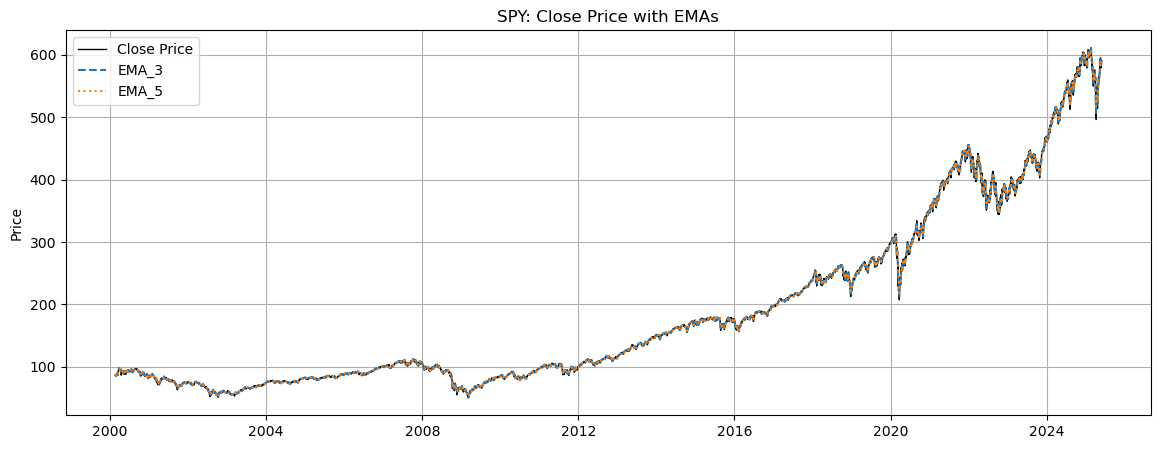

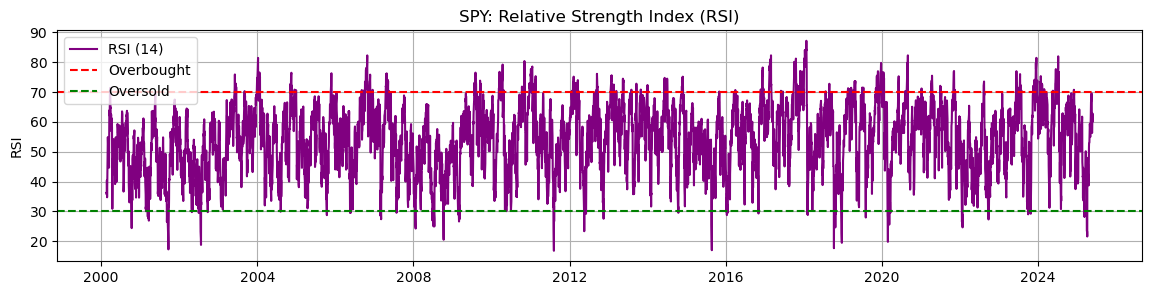

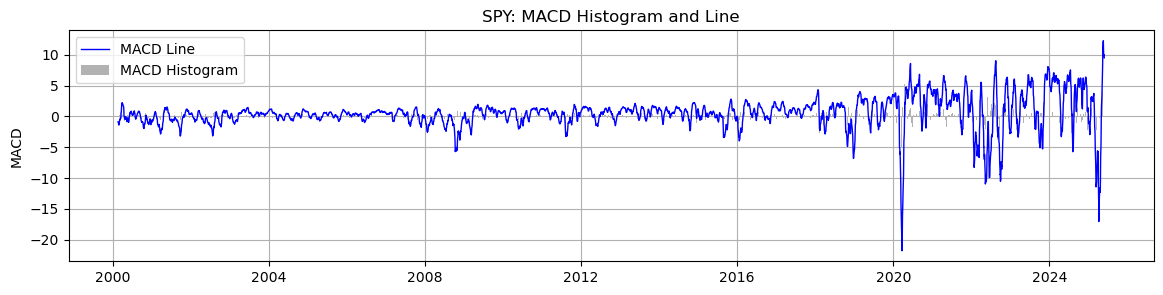

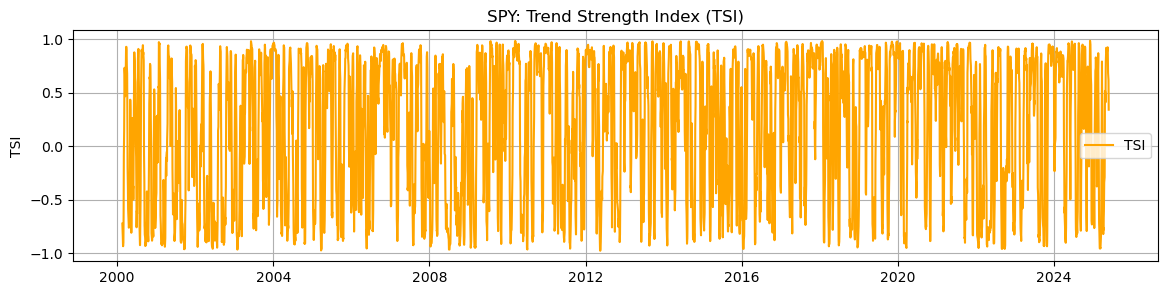

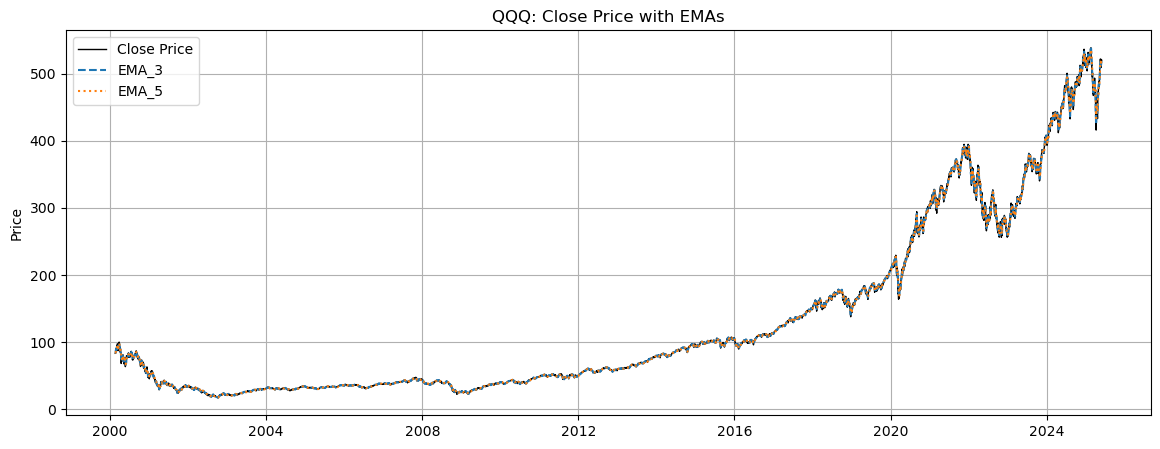

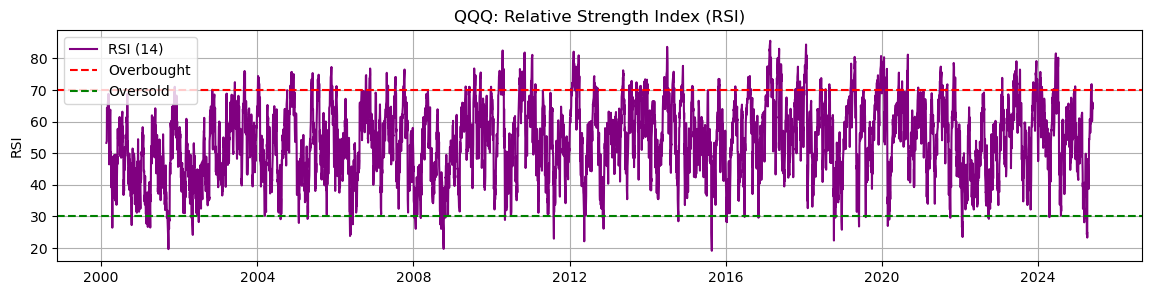

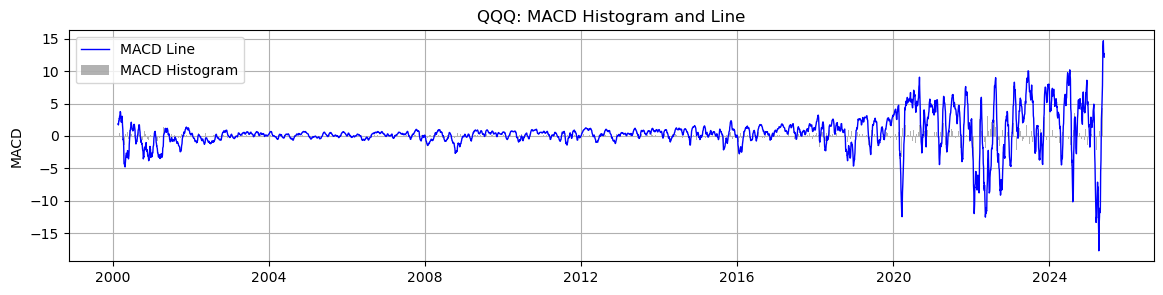

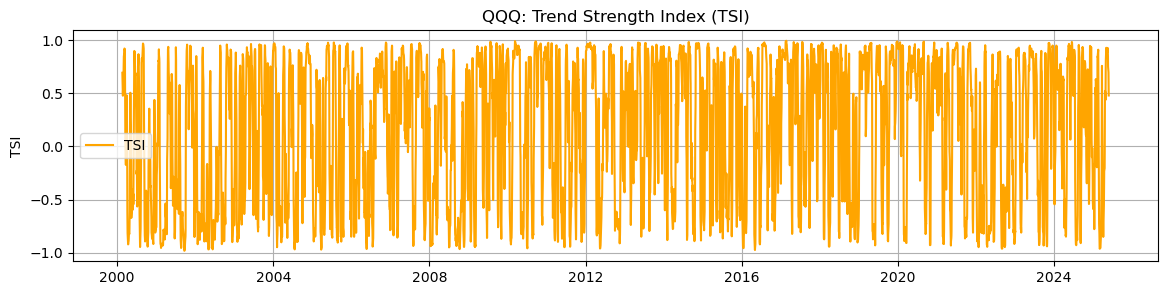

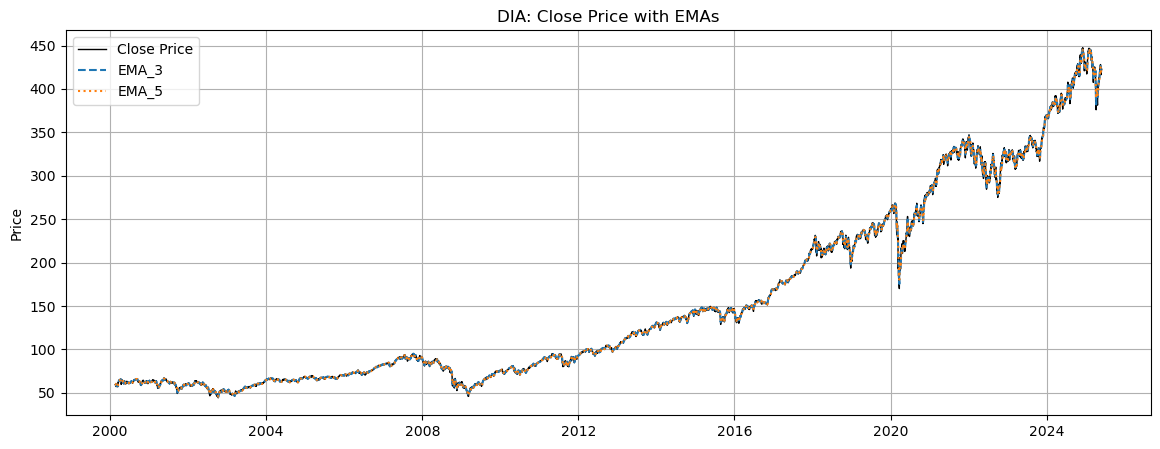

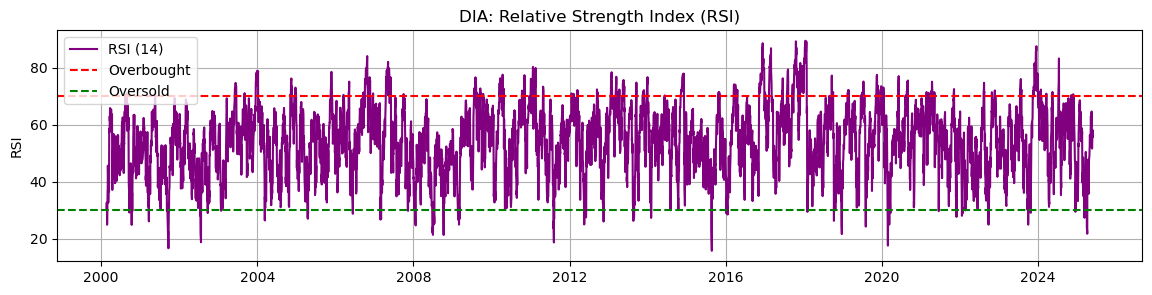

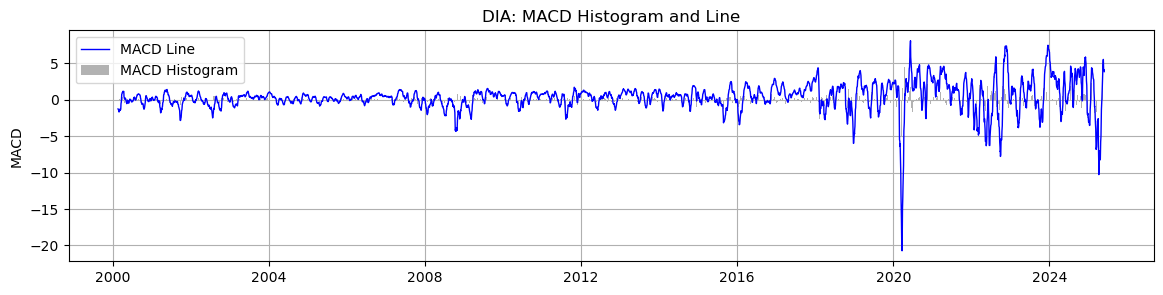

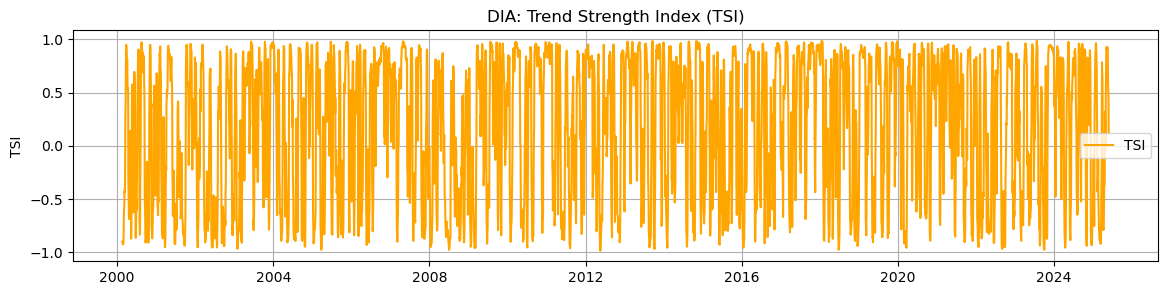

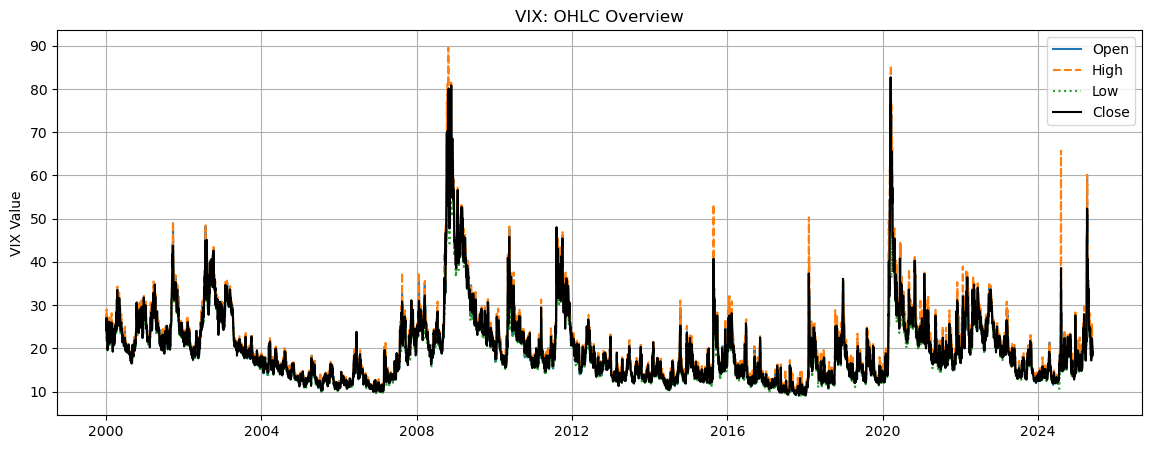

In [31]:
# Plot Close, EMAs, RSI, MACD, TSI for each stock
for ticker in ['SPY', 'QQQ', 'DIA']:
    df = data[ticker]

    # 1. Close + EMAs
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=1)
    ax.plot(df.index, df['EMA_3'], label='EMA_3', linestyle='--')
    ax.plot(df.index, df['EMA_5'], label='EMA_5', linestyle=':')
    ax.set_title(f"{ticker}: Close Price with EMAs")
    ax.set_ylabel("Price")
    ax.legend()
    plt.grid(True)
    plt.show()

    # 2. RSI
    fig, ax = plt.subplots(figsize=(14, 3))
    ax.plot(df.index, df['RSI'], color='purple', label='RSI (14)')
    ax.axhline(70, color='red', linestyle='--', label='Overbought')
    ax.axhline(30, color='green', linestyle='--', label='Oversold')
    ax.set_title(f"{ticker}: Relative Strength Index (RSI)")
    ax.set_ylabel("RSI")
    ax.legend()
    plt.grid(True)
    plt.show()

    # 3. MACD Line & Histogram
    fig, ax = plt.subplots(figsize=(14, 3))
    ax.bar(df.index, df['MACD_Histogram'], label='MACD Histogram', color='gray', alpha=0.6)
    ax.plot(df.index, df['MACD_Line'], label='MACD Line', color='blue', linewidth=1)
    ax.set_title(f"{ticker}: MACD Histogram and Line")
    ax.set_ylabel("MACD")
    ax.legend()
    plt.grid(True)
    plt.show()

    # 4. TSI (Trend Strength Index)
    fig, ax = plt.subplots(figsize=(14, 3))
    ax.plot(df.index, df['TSI'], color='orange', label='TSI')
    ax.set_title(f"{ticker}: Trend Strength Index (TSI)")
    ax.set_ylabel("TSI")
    ax.legend()
    plt.grid(True)
    plt.show()

# Plot VIX OHLC
vix_df = data['^VIX'].copy()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(vix_df.index, vix_df['Open'], label='Open', linestyle='-')
ax.plot(vix_df.index, vix_df['High'], label='High', linestyle='--')
ax.plot(vix_df.index, vix_df['Low'], label='Low', linestyle=':')
ax.plot(vix_df.index, vix_df['Close'], label='Close', color='black')
ax.set_title('VIX: OHLC Overview')
ax.set_ylabel("VIX Value")
ax.legend()
plt.grid(True)
plt.show()

## Decompose Close using Seasonal Decomposition

=== SPY - Seasonal Decomposition of Close ===


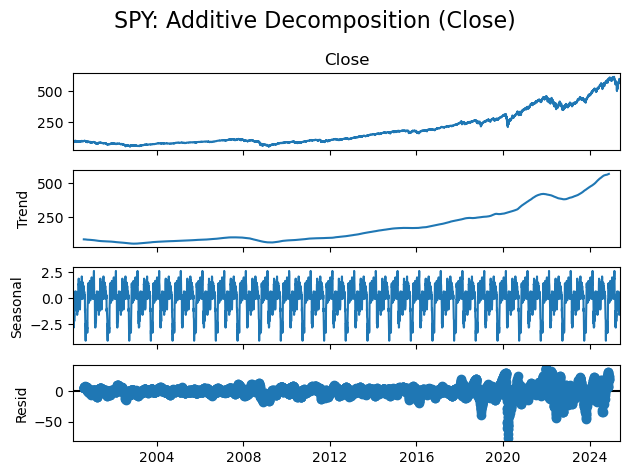

=== QQQ - Seasonal Decomposition of Close ===


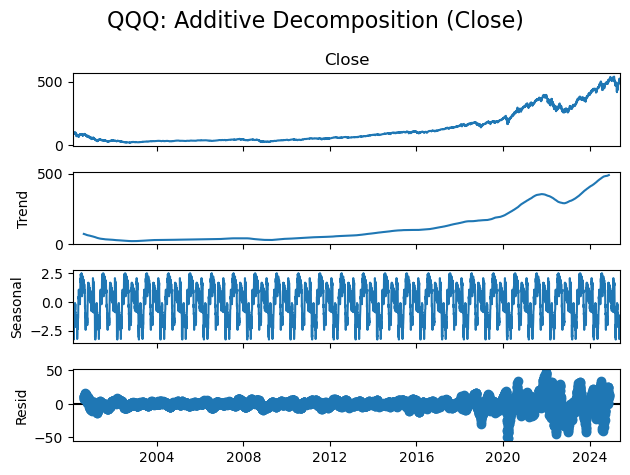

=== DIA - Seasonal Decomposition of Close ===


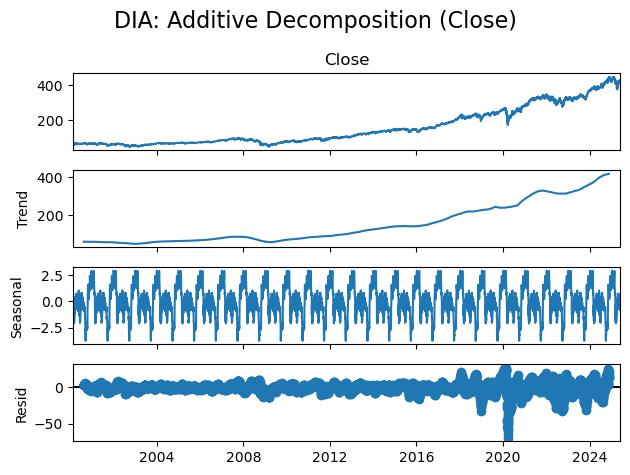

In [32]:
# Decompose Close using additive model
for ticker in ['SPY', 'QQQ', 'DIA']:
    df = data[ticker].copy()

    # Flatten MultiIndex columns if they exist
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Check if 'Close' column exists after flattening
    if 'Close' not in df.columns:
        print(f"Error: 'Close' column not found for {ticker}")
        continue

    # Drop NaNs and decompose
    df.dropna(subset=['Close'], inplace=True)

    # Perform seasonal decomposition (assumes ~252 trading days/year)
    result = seasonal_decompose(df['Close'], model='additive', period=252)
    
    print(f"=== {ticker} - Seasonal Decomposition of Close ===")
    result.plot()
    plt.suptitle(f'{ticker}: Additive Decomposition (Close)', fontsize=16)
    plt.tight_layout()
    plt.show()

### Analysis of Seasonal Decomposition (Close Prices of SPY, QQQ, DIA)
We performed seasonal decomposition on the “Close” price of each index using an additive model with a yearly period of 252 trading days. This helped us separate the Trend, Seasonal, and Residual components for clearer interpretation.

1. Observed (Original Series): Each ticker (SPY, QQQ, DIA) shows long-term upward price movement. Short-term fluctuations are present, likely due to market cycles, earnings seasons, and macroeconomic events. The presence of strong trends highlights the non-stationary nature of raw stock prices — an essential consideration when choosing modeling techniques.

2. Trend Component: A clear upward trend exists, especially after 2010, with QQQ (tech-heavy index) showing the steepest growth slope. Major events like the COVID-19 crash and rebound in 2020 are well captured. From an academic lens, this justifies applying differencing (i.e., d > 0) in ARIMA-type models. However, the smooth, long-term nature of the trend is not easily predictable using short-term lags — making ARIMA less suitable for forecasting in practice.

3. Seasonal Component: All three indices display annual seasonality, with repeating cycles that align roughly with calendar years. The seasonal amplitude is consistent, making the additive decomposition model appropriate. Academically, this supports the use of SARIMA/SARIMAX models which explicitly model seasonality. In practice, though, this regular seasonality is often overwhelmed by market shocks, volatility, and regime changes — conditions that ARIMA-based models struggle to adapt to.

4. Residual Component: Residuals should ideally reflect random noise. In our case, residuals show clear volatility clustering, particularly during high-impact periods like 2008 and 2020. Post-2020, residual noise increases in both amplitude and irregularity — reflecting a shift in market behavior that traditional statistical models cannot easily capture.

## Augmented Dickey-Fuller (ADF) Test for Stationarity

In [33]:
# Perform ADF test on Close
for ticker in ['SPY', 'QQQ', 'DIA']:
    df = data[ticker].copy()

    # Flatten MultiIndex columns if needed
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    if 'Close' not in df.columns:
        print(f"Error: 'Close' column not found for {ticker}")
        continue

    # Drop missing values from 'Close'
    df.dropna(subset=['Close'], inplace=True)

    # Run Augmented Dickey-Fuller Test
    result = adfuller(df['Close'])

    print(f"\n=== ADF Test for {ticker} Close ===")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value:.4f}")
    
    if result[1] <= 0.05:
        print("Conclusion: Reject H0 → The series is likely stationary.")
    else:
        print("Conclusion: Fail to reject H0 → The series is likely non-stationary.")


=== ADF Test for SPY Close ===
ADF Statistic: 2.6157
p-value: 0.9991
Critical Value (1%): -3.4314
Critical Value (5%): -2.8620
Critical Value (10%): -2.5670
Conclusion: Fail to reject H0 → The series is likely non-stationary.

=== ADF Test for QQQ Close ===
ADF Statistic: 2.6058
p-value: 0.9991
Critical Value (1%): -3.4314
Critical Value (5%): -2.8620
Critical Value (10%): -2.5670
Conclusion: Fail to reject H0 → The series is likely non-stationary.

=== ADF Test for DIA Close ===
ADF Statistic: 1.9267
p-value: 0.9986
Critical Value (1%): -3.4314
Critical Value (5%): -2.8620
Critical Value (10%): -2.5670
Conclusion: Fail to reject H0 → The series is likely non-stationary.


### Analysis of ADF Results
To assess whether the stock price series for SPY, QQQ, and DIA are stationary, we applied the Augmented Dickey-Fuller (ADF) test. Stationarity is a key assumption for ARIMA-based models. 

Interpretation:
1. For all three indices, the ADF statistic is positive, and the p-values are extremely high (> 0.99).
2. This means we fail to reject the null hypothesis (H₀), which assumes the data has a unit root, i.e., it is non-stationary.
3. Non-stationarity implies that the mean, variance, and autocorrelation change over time — a typical trait of financial price series.

Although non-stationarity is a signal that differencing (the 'd' in ARIMA) is technically needed, it also reinforces a broader limitation:

Real-world stock prices are inherently non-stationary and driven by nonlinear, external forces (e.g., news, sentiment, earnings, macroeconomics). While ARIMA can be applied after differencing, it struggles to model market dynamics, especially compared to ML/DL methods.

Thus, we use the ADF test to validate academic understanding, not to justify ARIMA as a forecasting tool. Instead, our final models are based on XGBoost, LSTM, and GRU, which handle non-stationarity, non-linearity, and memory effects far better.

## Autocorrelation ACF / PACF Plots for Close and Indicators



=== ACF / PACF for SPY ===

→ Plotting ACF/PACF for: Close


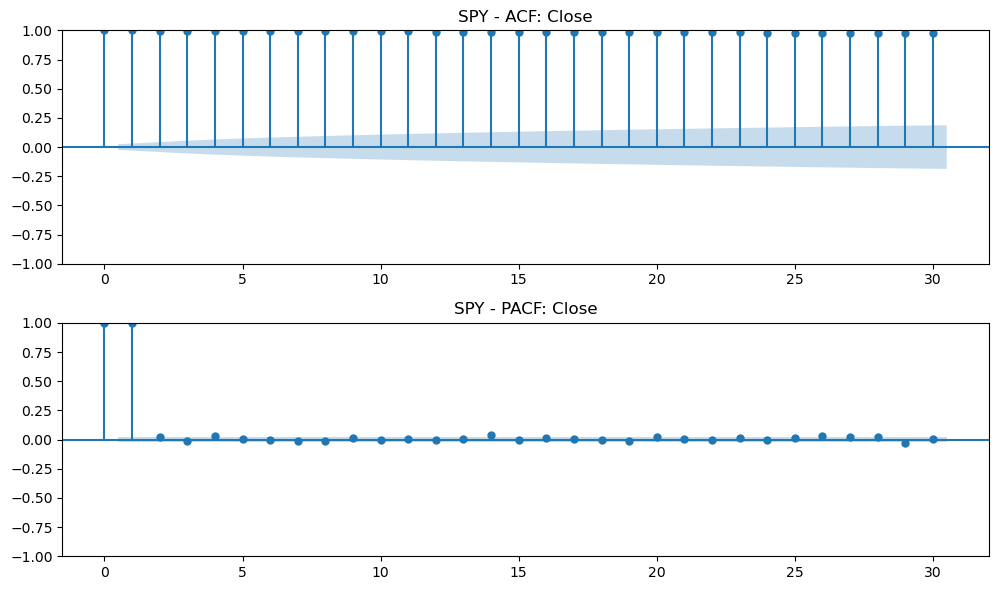


→ Plotting ACF/PACF for: EMA_3


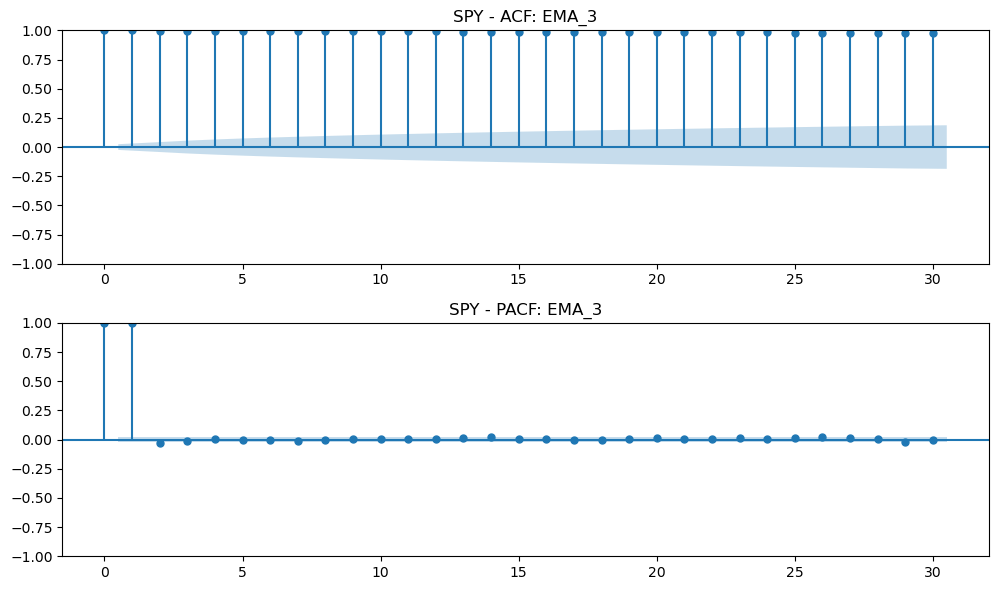


→ Plotting ACF/PACF for: EMA_5


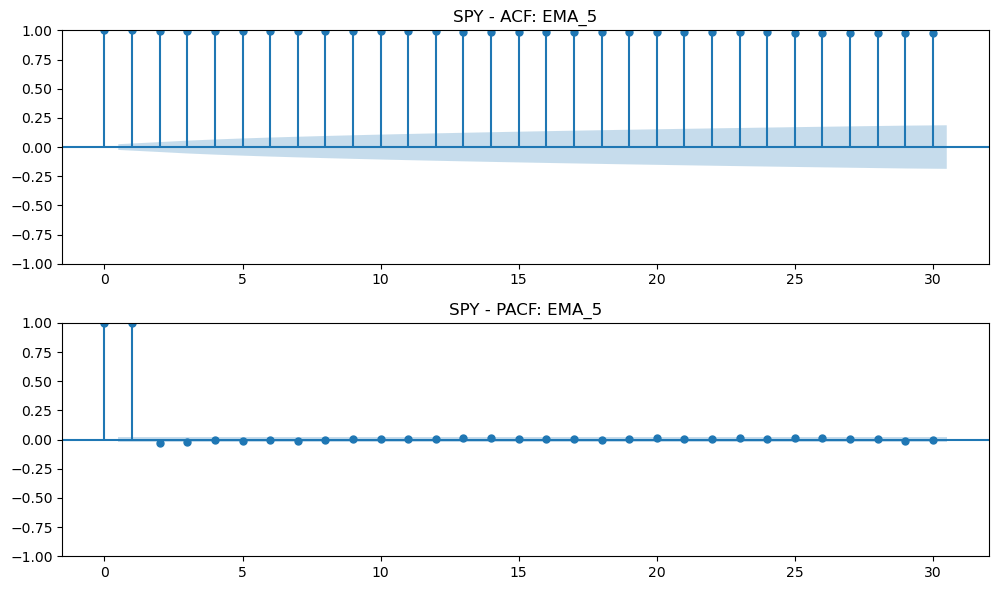


→ Plotting ACF/PACF for: RSI


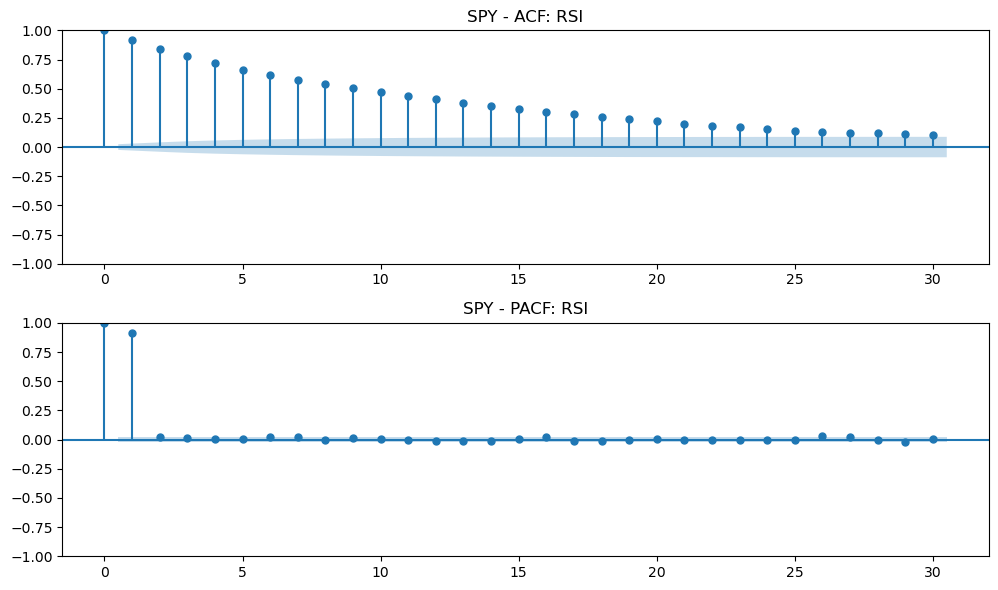


→ Plotting ACF/PACF for: MACD_Histogram


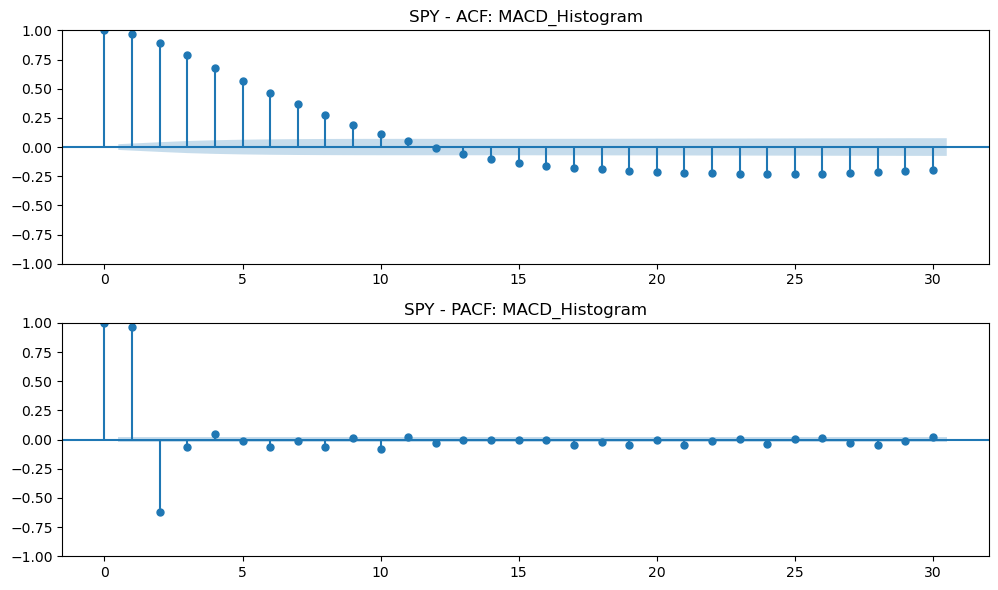


→ Plotting ACF/PACF for: TSI


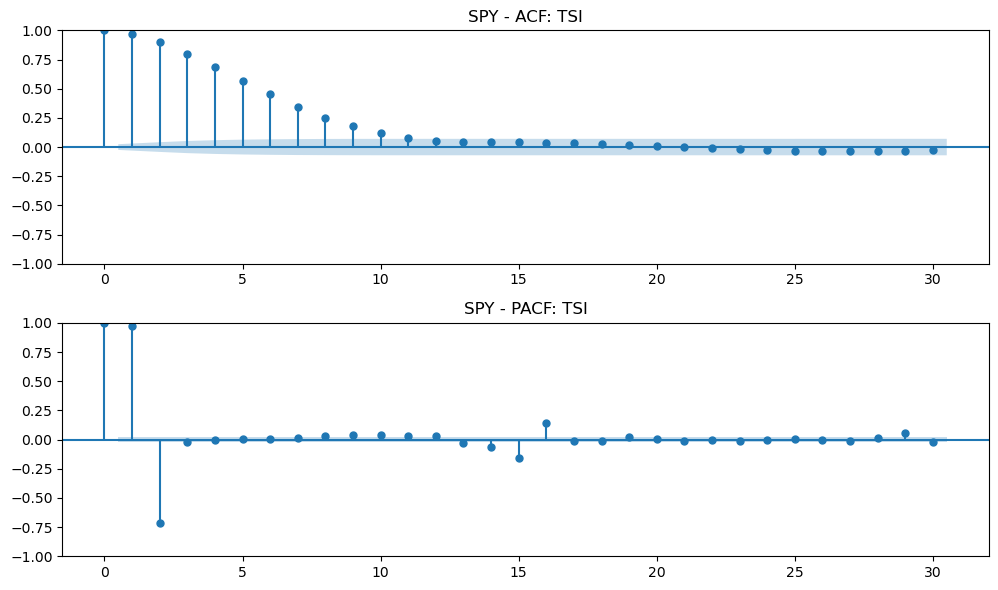



=== ACF / PACF for QQQ ===

→ Plotting ACF/PACF for: Close


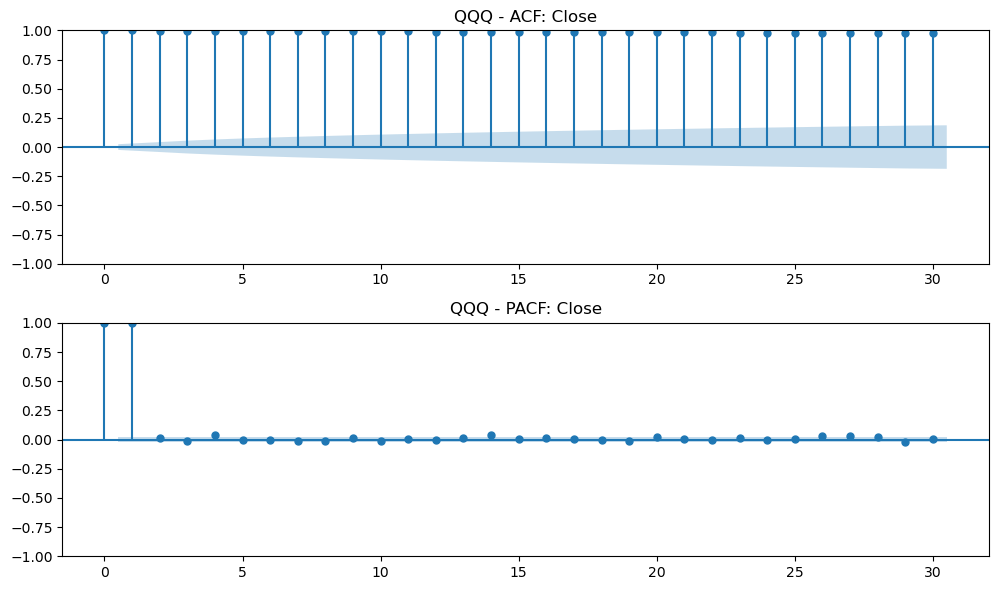


→ Plotting ACF/PACF for: EMA_3


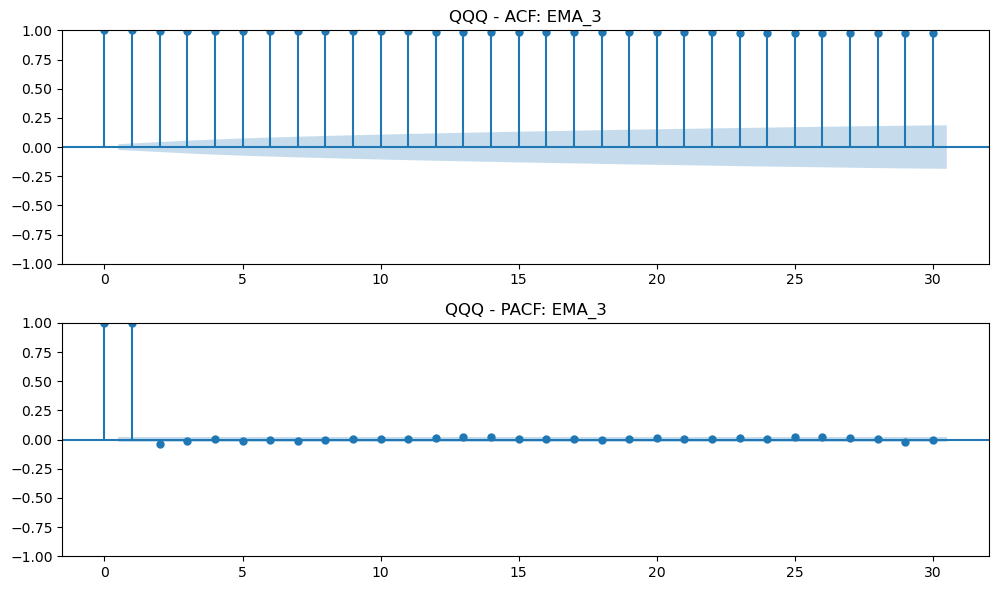


→ Plotting ACF/PACF for: EMA_5


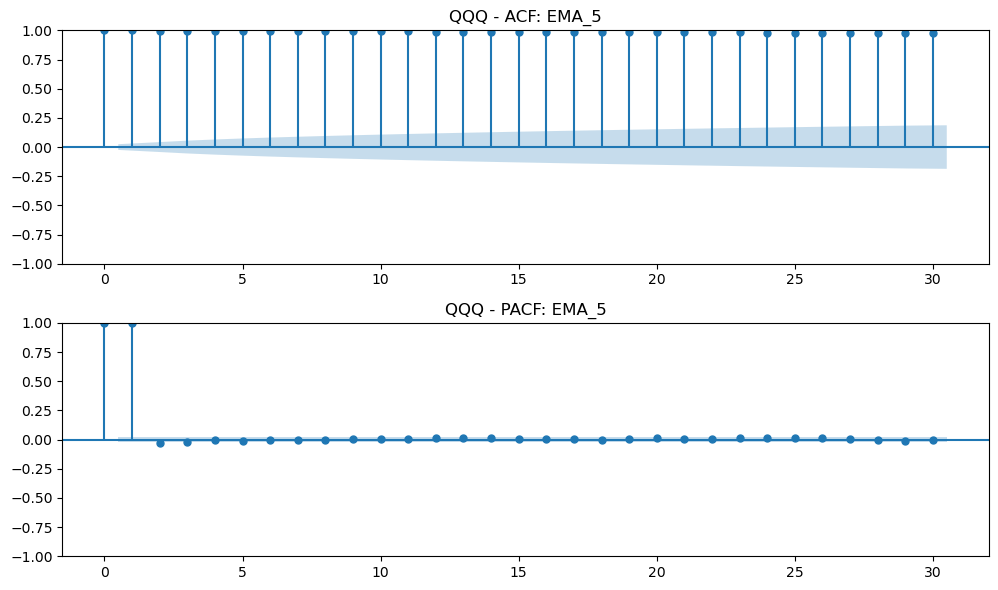


→ Plotting ACF/PACF for: RSI


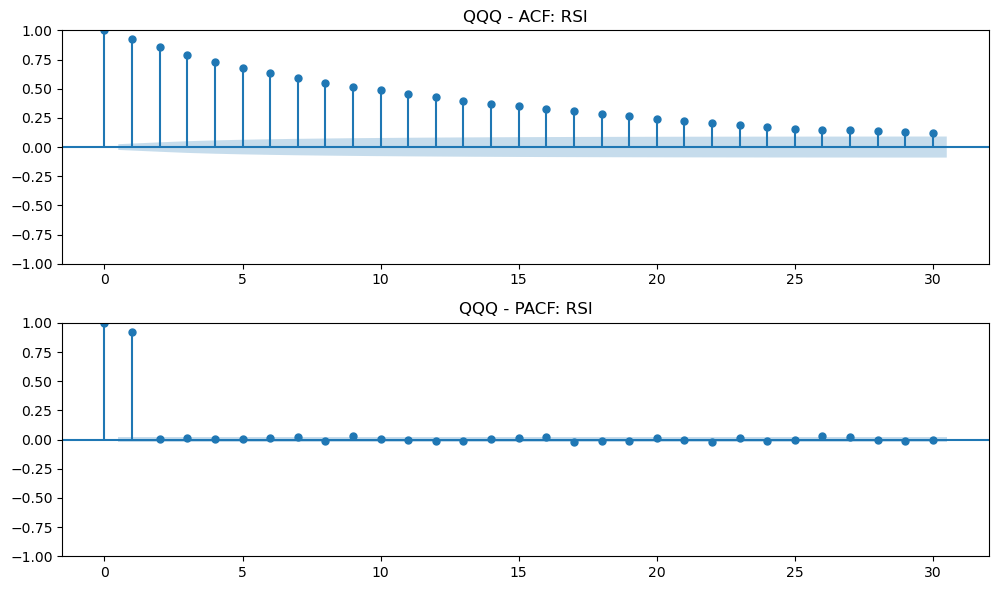


→ Plotting ACF/PACF for: MACD_Histogram


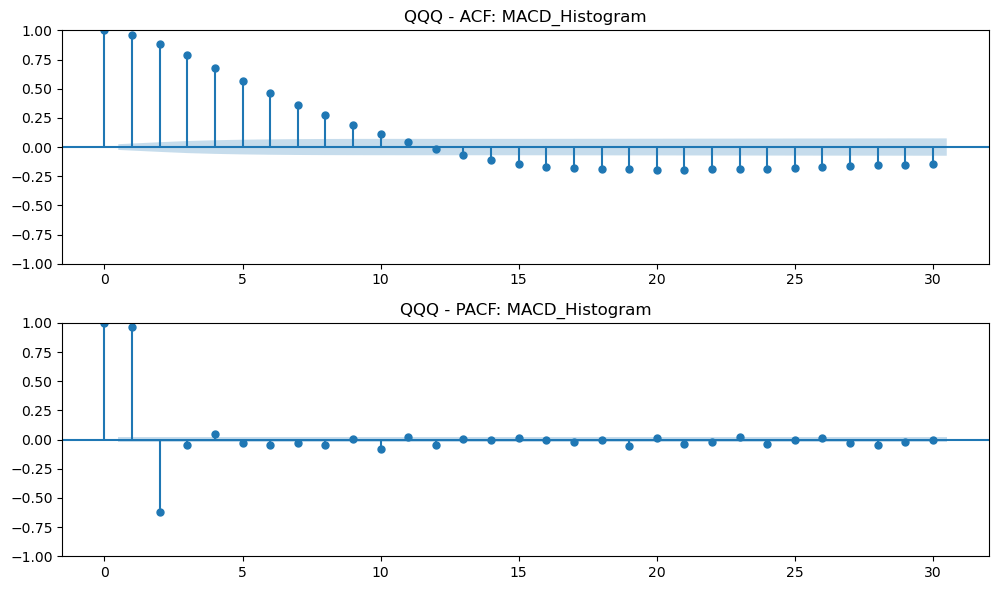


→ Plotting ACF/PACF for: TSI


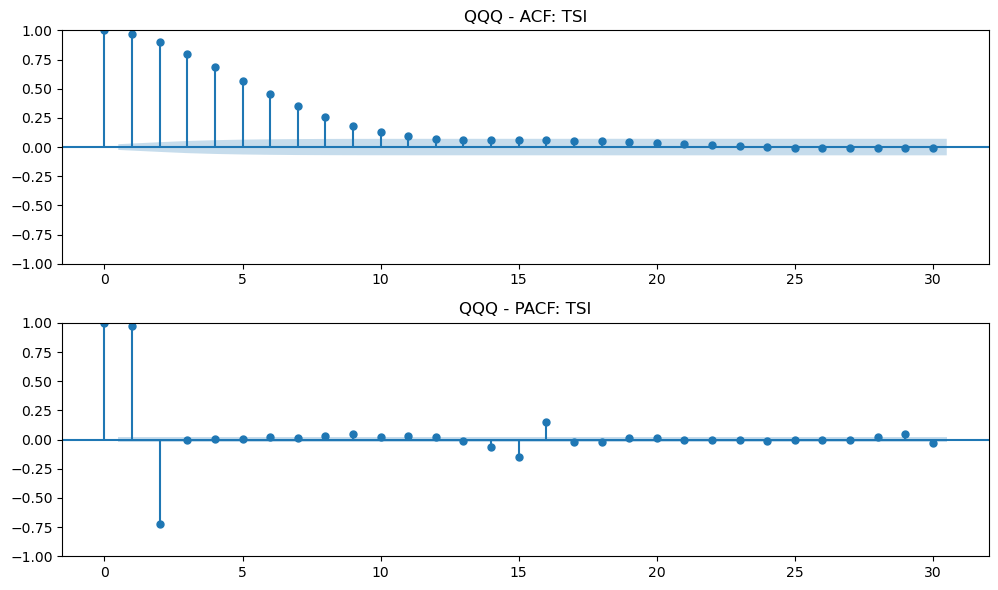



=== ACF / PACF for DIA ===

→ Plotting ACF/PACF for: Close


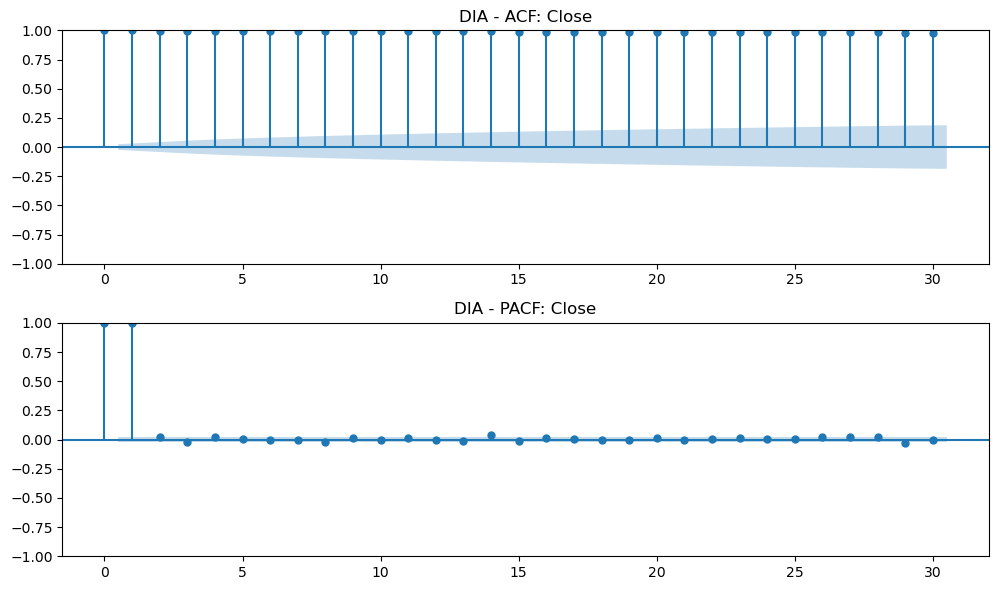


→ Plotting ACF/PACF for: EMA_3


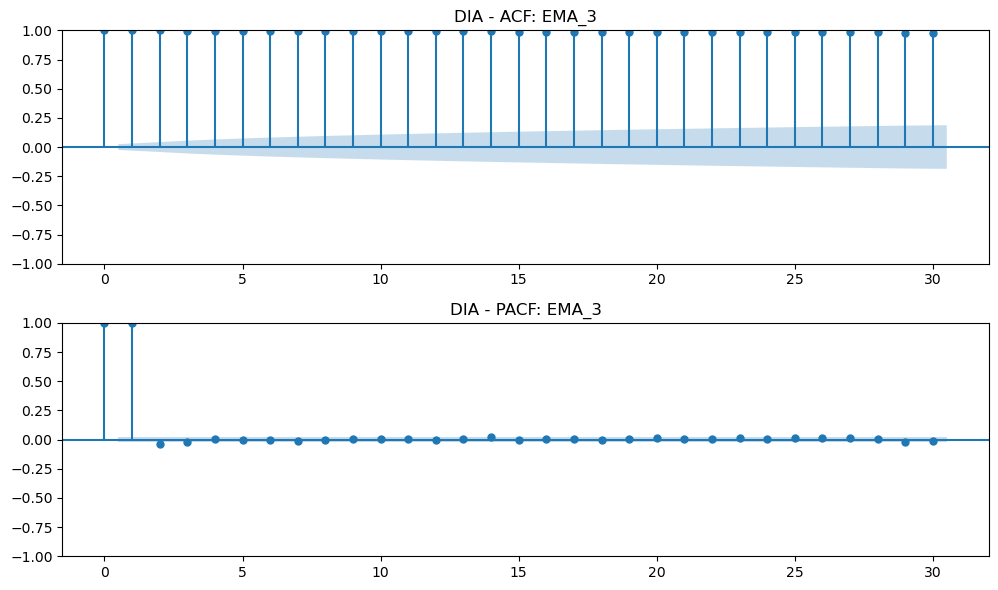


→ Plotting ACF/PACF for: EMA_5


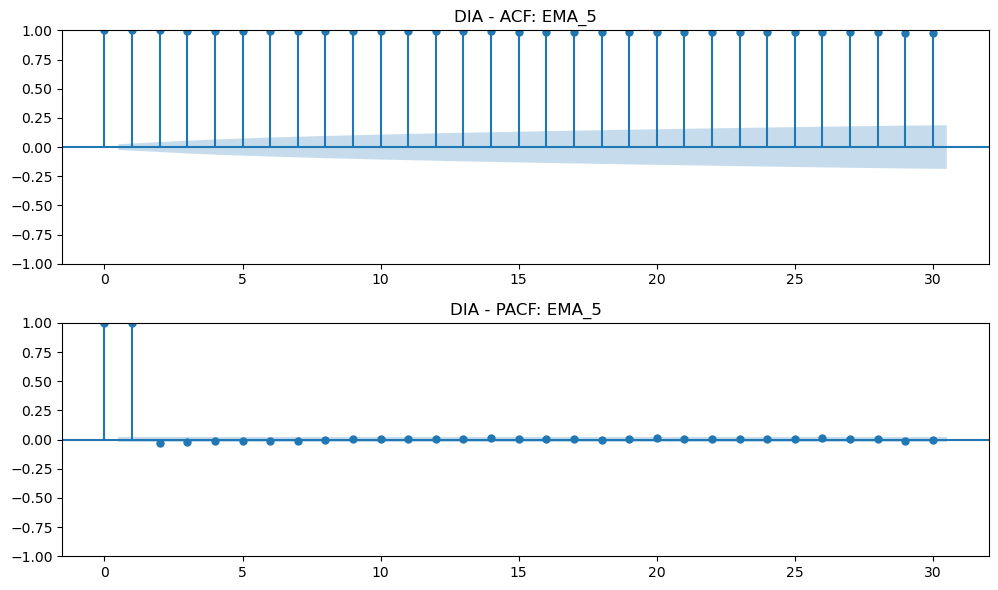


→ Plotting ACF/PACF for: RSI


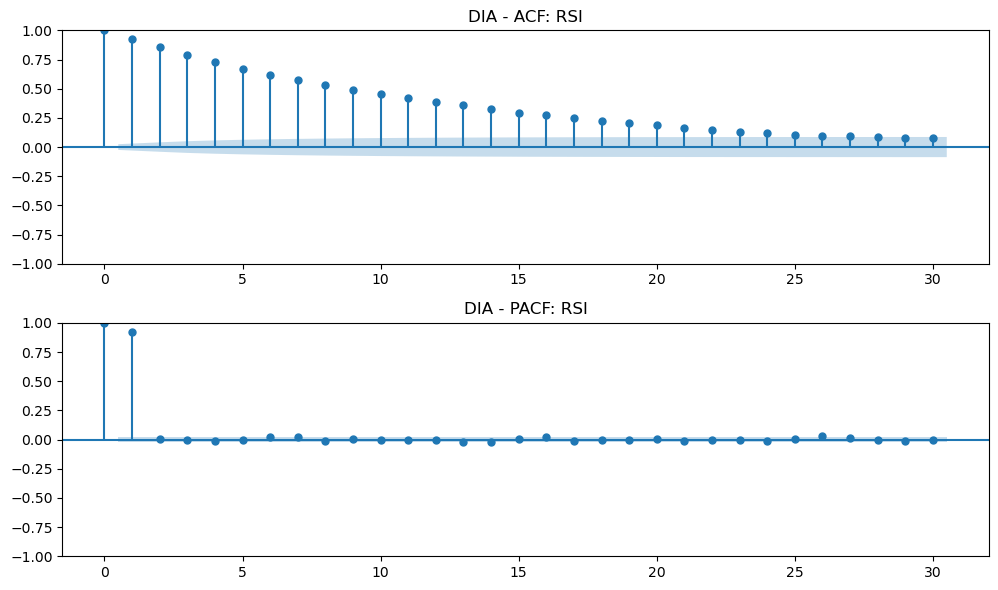


→ Plotting ACF/PACF for: MACD_Histogram


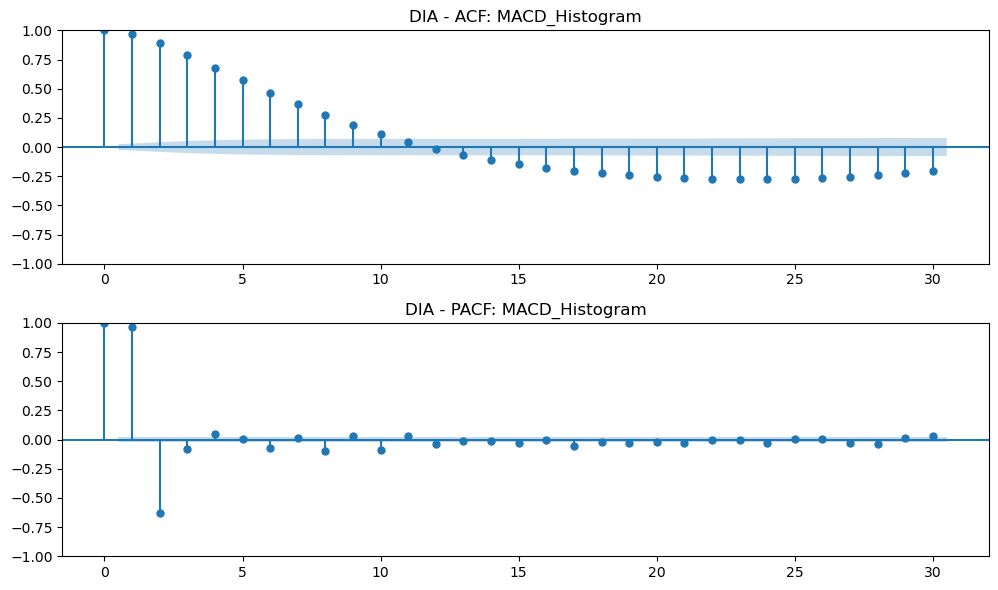


→ Plotting ACF/PACF for: TSI


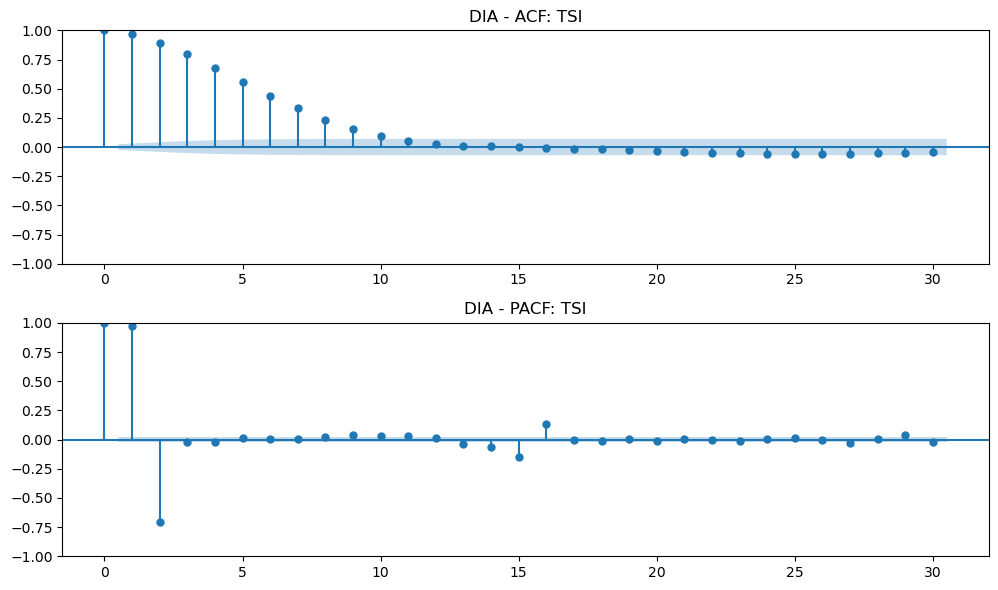

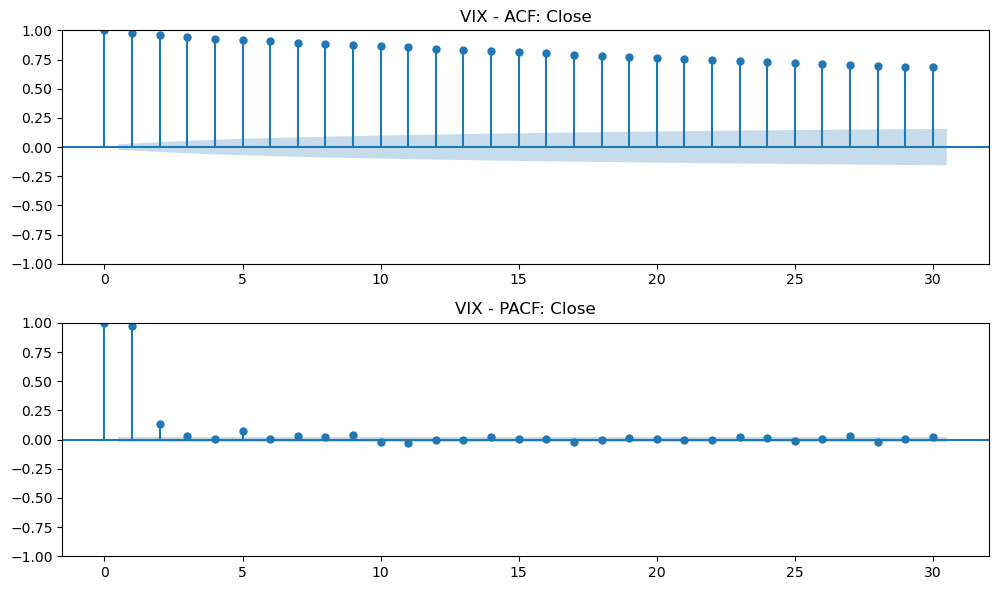

In [34]:
# Indicators to analyze
indicators = ['Close', 'EMA_3', 'EMA_5', 'RSI', 'MACD_Histogram', 'TSI']

for ticker in ['SPY', 'QQQ', 'DIA']:
    print(f"\n\n=== ACF / PACF for {ticker} ===")
    df = data[ticker].copy()
    df.dropna(inplace=True)

    for ind in indicators:
        print(f"\n→ Plotting ACF/PACF for: {ind}")
        fig, ax = plt.subplots(2, 1, figsize=(10, 6))
        plot_acf(df[ind], ax=ax[0], lags=30) # Each lag = 1 day
        ax[0].set_title(f"{ticker} - ACF: {ind}")

        plot_pacf(df[ind], ax=ax[1], lags=30, method='ywm')
        ax[1].set_title(f"{ticker} - PACF: {ind}")
        plt.tight_layout()
        plt.show()

# ACF/PACF for VIX OHLC
vix_df = data['^VIX'].copy()
vix_df.dropna(inplace=True)

for col in ['Close']:
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(vix_df[col], ax=ax[0], lags=30)
    ax[0].set_title(f"VIX - ACF: {col}")

    plot_pacf(vix_df[col], ax=ax[1], lags=30, method='ywm')
    ax[1].set_title(f"VIX - PACF: {col}")
    plt.tight_layout()
    plt.show()

### Autocorrelation Results Analysis
To understand the time-dependent structure of our dataset, we conducted autocorrelation analysis on six key indicators: Close, EMA_3, EMA_5, RSI, MACD_Line, and TSI, across SPY, QQQ, and DIA. In addition, we analyzed the Close of the VIX index as a measure of volatility. For each indicator, we plotted both the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) using 30 lags (Each lag = 1 day). 

### What Are ACF and PACF?
1. ACF (Autocorrelation Function): Measures the correlation of a time series with its past values (lags), including both direct and indirect influences. Think of ACF as “how much is today’s price like yesterday’s, the day before, etc. — including all indirect influences.”
2. PACF (Partial Autocorrelation Function): Measures the direct correlation between a series and its lagged values, after removing the effect of shorter lags. PACF is “how much is today’s price directly related to the price exactly n days ago, ignoring intermediate effects.”

- Example: ACF at lag=3 measures how today’s value is related to the value 3 days ago, including indirect influence via lags 1 and 2. PACF at lag=3 isolates only the direct effect of day-3, holding lags 1 and 2 constant.

### Interpreting the Charts
1. Price and Trend Indicators (Close, EMA_3, EMA_5):
- ACF: These indicators exhibit extremely strong and persistent autocorrelation, with all lags above the 95% confidence level and no sign of decay even after 30 lags. This is characteristic of strong non-stationarity.
- PACF: Sharp spikes only at lag 1 or 2, then values rapidly stabilize near zero. This suggests that recent past prices have the most direct influence — a typical AR(1)/AR(2) pattern.

2. Momentum Indicators (RSI, TSI, MACD_Histogram):
- RSI & TSI ACF: Display moderate decay, gradually dropping into the confidence band by around lag 10–15, indicating short-term memory but weaker long-term persistence.
- MACD_Histogram ACF: Also shows steady decay, though it crosses into the noise band slightly faster (~lag 11), indicating a more compact memory window.
- PACF for all three: Lag 1 is dominant, with smaller or negative spikes at lag 2–3, supporting their role as short-horizon indicators.

3. VIX Close:
- ACF: Shows strong autocorrelation with a gradual decay, confirming volatility clustering.
- PACF: Drops sharply after lag 1, meaning short-term volatility is directly linked to the most recent values

### Do We Need Differencing?
- In ARIMA-based models: The slow decay in ACF, particularly for Close, EMA_3, and MACD_Histogram, indicates non-stationarity, which typically requires differencing (d > 0). This transformation removes trend and seasonality, making the data stationary.

- In Machine Learning models (XGBoost, LSTM, GRU): Differencing is not applied, because ML/DL models can learn patterns directly from raw, non-stationary data. Differencing may remove trend direction, which is essential for making directional predictions (e.g., up/down).

### Summary and Justification
The ACF/PACF analysis confirms that our price-related indicators are non-stationary and exhibit long memory, which explains why classical models like ARIMA may require differencing to achieve stationarity.

But since our goal is to build predictive models using XGBoost, LSTM, and GRU, differencing is not only unnecessary, it would be counterproductive. These models perform best when provided with raw inputs that include trend, seasonality, and volatility patterns.

Therefore, ACF and PACF diagnostics are included to satisfy academic completeness, not as preprocessing tools. We intentionally retain all information in its raw form to allow ML/DL models to extract maximum predictive value.

# 5. Correlation Analysis

=== Correlation Analysis for SPY ===


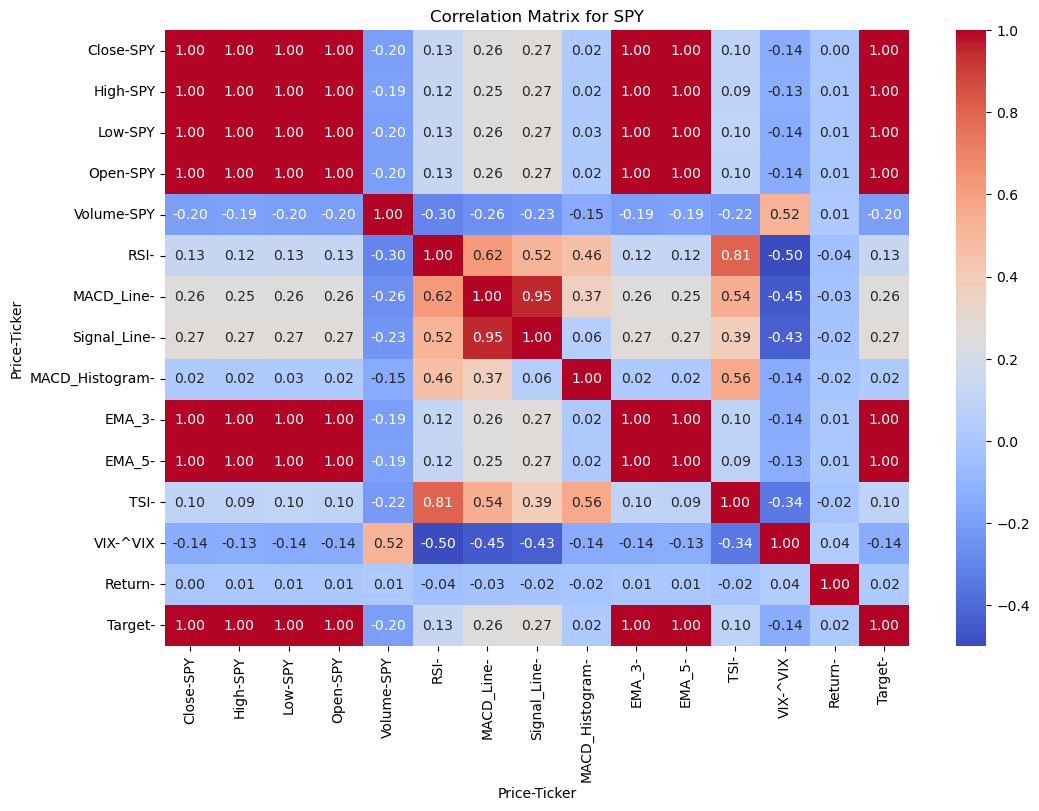

=== Correlation Analysis for QQQ ===


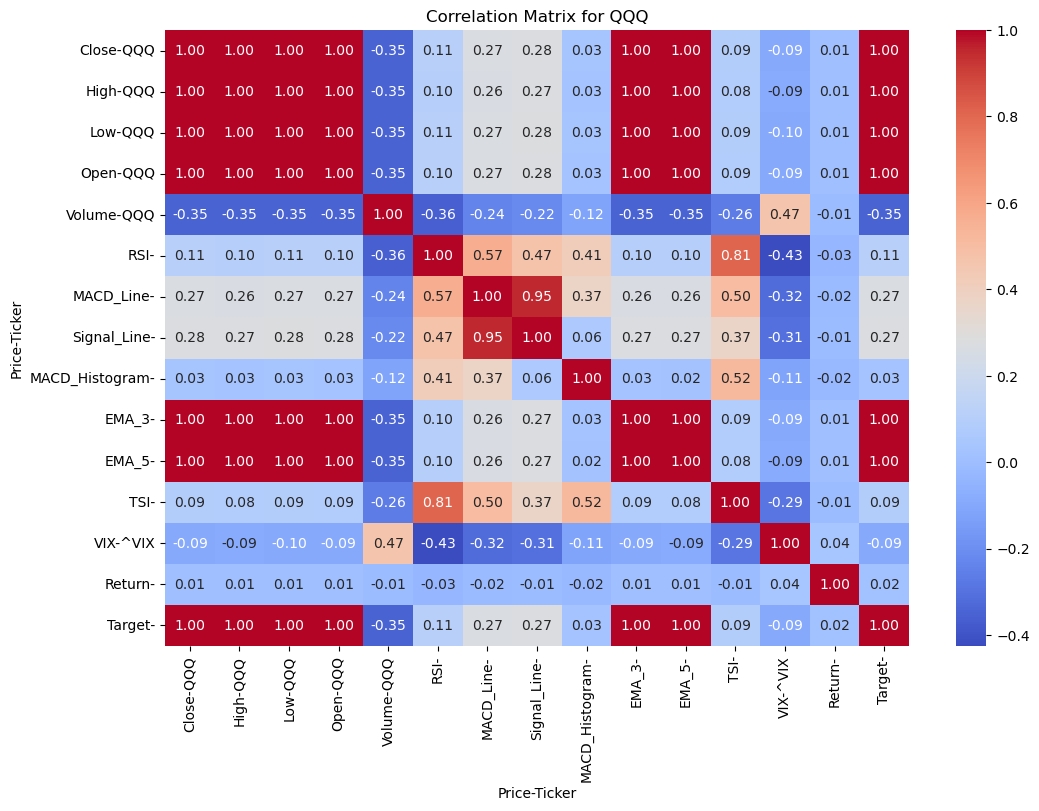

=== Correlation Analysis for DIA ===


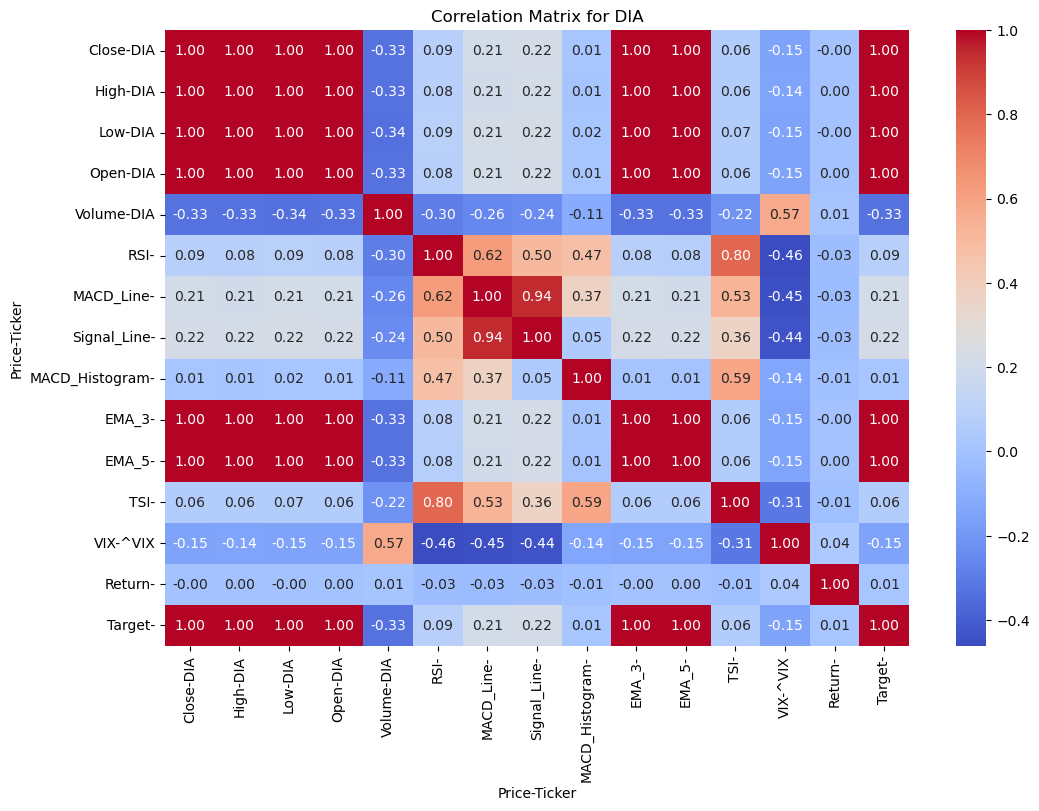

In [35]:
# Function to compute and plot correlation matrix
def plot_correlation_matrix(df, ticker):
    df = df.copy()
    
    # Drop rows with NaN values (especially from indicators and shift)
    df.dropna(inplace=True)
    
    # Add the target column (next day's closing price)
    df['Target'] = df['Close'].shift(-1)

    # Re-drop last row (now has NaN in Target)
    df.dropna(inplace=True)

    # Compute correlation matrix
    correlation = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f'Correlation Matrix for {ticker}')
    plt.show()

# Apply to all 3 tickers
for ticker in ['SPY', 'QQQ', 'DIA']:
    print(f"=== Correlation Analysis for {ticker} ===")
    plot_correlation_matrix(data[ticker], ticker)

### Correlation Analysis
To evaluate the linear relationships between input features and the next day’s stock price (Target), we computed correlation matrices for SPY, QQQ, and DIA. This type of analysis differs from autocorrelation, which looks at how a variable relates to its own past values (lags). Instead, correlation matrices assess how different variables relate to one another at the same point in time — crucial when selecting features for machine learning models.

### Key Observations from the Correlation Matrices:
1. Strong Redundancy Among Price Columns: As expected, Close, Open, High, and Low are perfectly or near-perfectly correlated (correlation ≈ 1.00). This indicates redundancy — these values move in tandem, which is typical for OHLC data.

2. Target Variable (Next Day's Close): The Target (i.e., Close.shift(-1)) shows moderate positive correlation with current-day Close, Open, High, and Low, but weaker correlation with most technical indicators:

3. MACD_Line, RSI, and TSI show weak-to-moderate correlations (≈ 0.10–0.30).

4. MACD_Histogram, Volume, and VIX show little to no direct correlation with Target.

5. TSI and RSI Relationship: TSI (Trend Strength Index) shows a very strong correlation with RSI (≥ 0.80 across all tickers). While this suggests overlap in what they measure, they capture different aspects — RSI focuses on momentum and overbought/oversold levels, while TSI measures trend strength based on linearity.

6. VIX Correlation: The VIX index shows negative correlation with most price indicators (e.g., around -0.10 to -0.15 with Close, Open, etc.), which makes sense as VIX tends to rise during market stress.

### Implications for Feature Selection
Although some features like Volume, MACD_Histogram, and VIX show weak correlation with the Target, they are still retained in the feature set. This is intentional. Weak correlation does not mean useless — especially in machine learning:

- Some features may be non-linearly predictive (which correlation can’t capture). Others may become more useful when combined with different features (feature interactions).

- Features with strong autocorrelation (e.g., MACD_Line, EMA_3, Close) might still contain lag-based predictive signals valuable for time-aware models like LSTM.

Hence, correlation matrices help us reassess the value of our features — not to blindly drop them, but to identify overlaps, redundancy, and potential new additions. Based on our results, we will use the following key features to train the models: Close, Open, High, Low, Volume, EMA_3, EMA_5, RSI, MACD_Histogram, TSI, and VIX. 

Note: MACD_Line and Signal_Line are not included as the relationship between them is shown by MACD_Histogram. 

# 6. Flatten MultiIndex Columns for Training

In [36]:
# FLATTEN MultiIndex columns
df_flat = data['SPY']  # or whatever ticker
df_flat.columns = df_flat.columns.get_level_values(0)
# Now df_flat.columns might look like:
#   ['Close','High','Low','Open','Volume','RSI','MACD_Line','Signal_Line','MACD_Histogram',
#    'EMA_3','EMA_5','TSI','VIX','Return']
#
# Replace data['SPY'] with this flattened version:
data['SPY'] = df_flat.copy()

# Repeat for QQQ and DIA:
for ticker in ['QQQ','DIA']:
    df_flat = data[ticker]
    df_flat.columns = df_flat.columns.get_level_values(0)
    data[ticker] = df_flat.copy()

# 7. Define the Metrics File

In [37]:
METRICS_FILE = "model_metrics.csv"

# write header if this is the first run
if not os.path.exists(METRICS_FILE):
    with open(METRICS_FILE, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "ticker", "model",
            "MAE", "MSE", "RMSE", "MAPE", "R2", "Pearson"
        ])

# 8. Train XGBoost Model



=== TICKER: SPY ===
Total days: 6,356   |   Initial train size: 5,084
Trying params: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 5, 'gamma': 1}
Validation MSE: 4454.435995
Trying params: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_lambda': 3, 'gamma': 0.5}
Validation MSE: 4437.614667
Trying params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
Validation MSE: 4387.373458
Best hyperparameters for SPY: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
Trained through 2020-05-05, forecasted 2020-05-06, AE=1.40, SE=1.95, APE=0.53%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=1.88, SE=3.55, APE=0.60%, R²_so_far=0.9537
Trained through 2021-02-19, forecasted 2021-

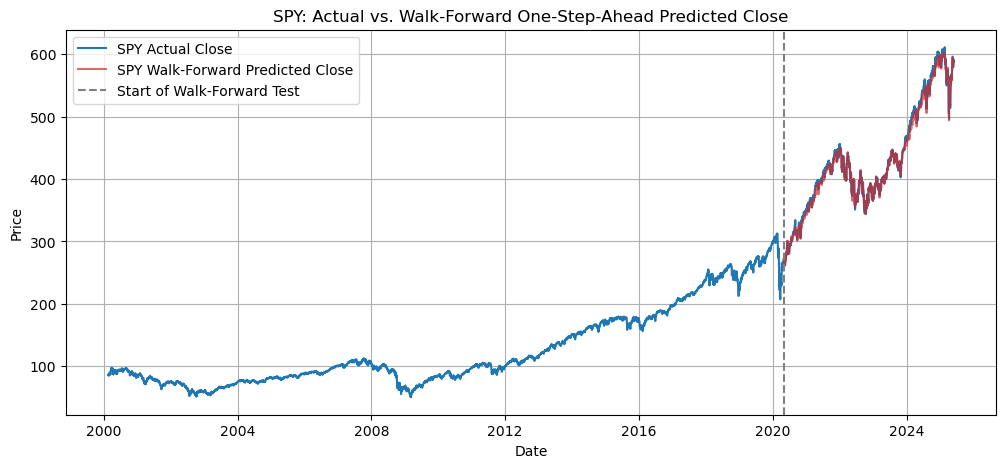

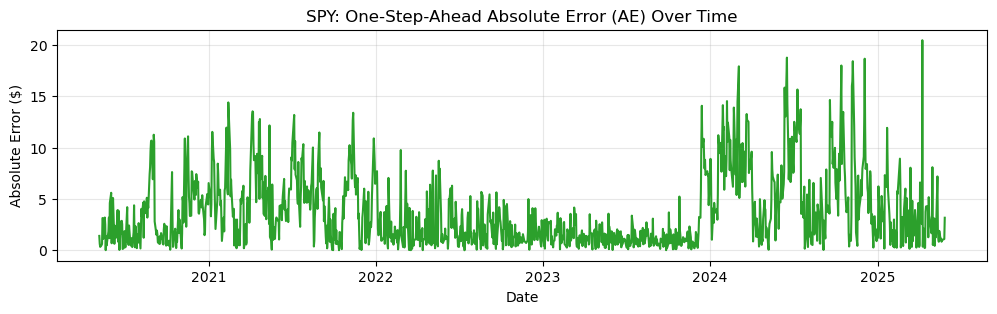

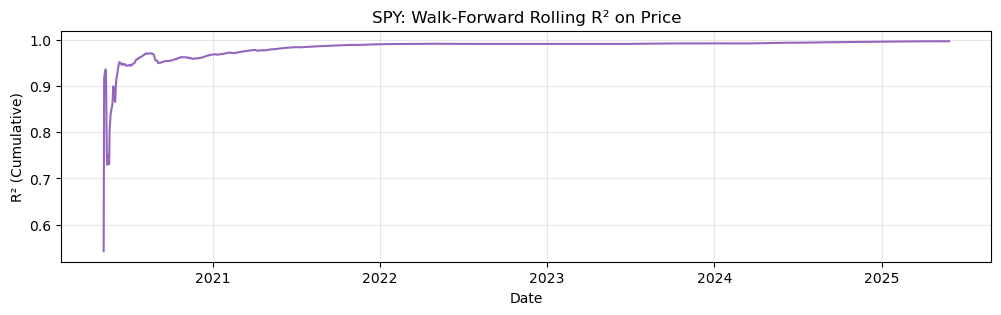



=== TICKER: QQQ ===
Total days: 6,356   |   Initial train size: 5,084
Trying params: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 5, 'gamma': 1}
Validation MSE: 3271.773453
Trying params: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_lambda': 3, 'gamma': 0.5}
Validation MSE: 3292.798079
Trying params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
Validation MSE: 3264.424562
Best hyperparameters for QQQ: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
Trained through 2020-05-05, forecasted 2020-05-06, AE=0.35, SE=0.12, APE=0.17%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=2.77, SE=7.67, APE=1.03%, R²_so_far=0.8629
Trained through 2021-02-19, forecasted 2021-

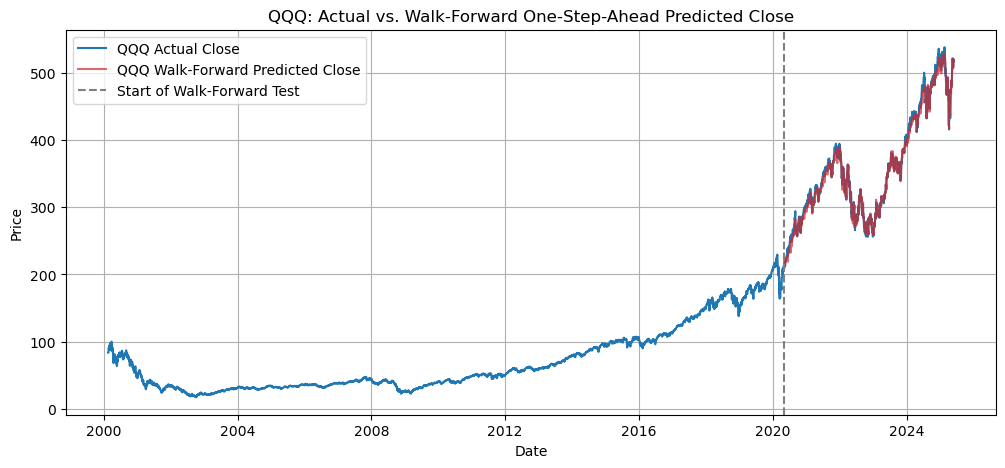

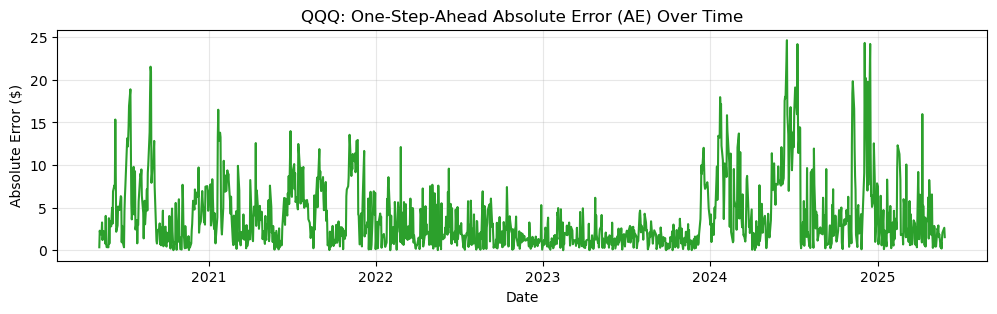

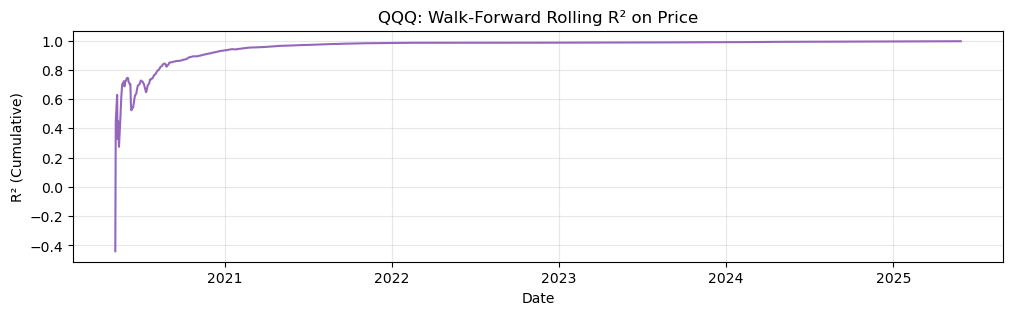



=== TICKER: DIA ===
Total days: 6,356   |   Initial train size: 5,084
Trying params: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 5, 'gamma': 1}
Validation MSE: 4356.002394
Trying params: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_lambda': 3, 'gamma': 0.5}
Validation MSE: 4362.256931
Trying params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
Validation MSE: 4324.347752
Best hyperparameters for DIA: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
Trained through 2020-05-05, forecasted 2020-05-06, AE=1.34, SE=1.81, APE=0.62%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=1.21, SE=1.46, APE=0.47%, R²_so_far=0.9832
Trained through 2021-02-19, forecasted 2021-

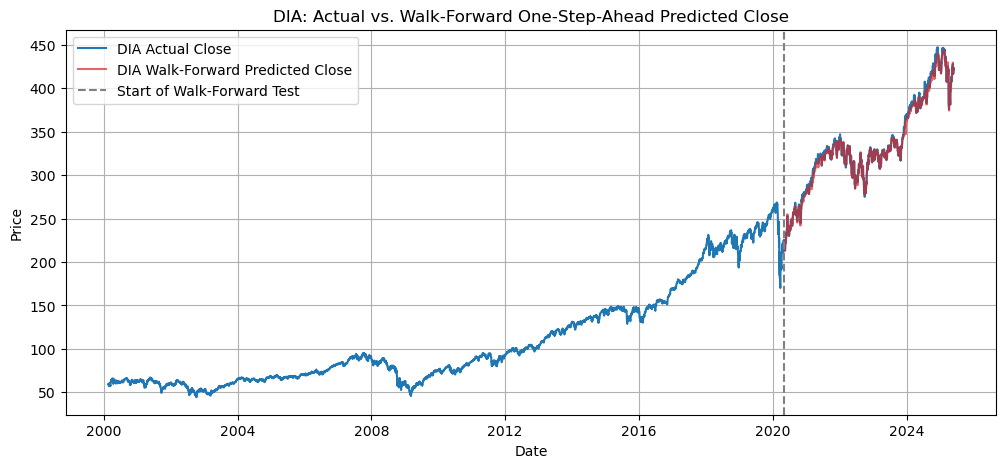

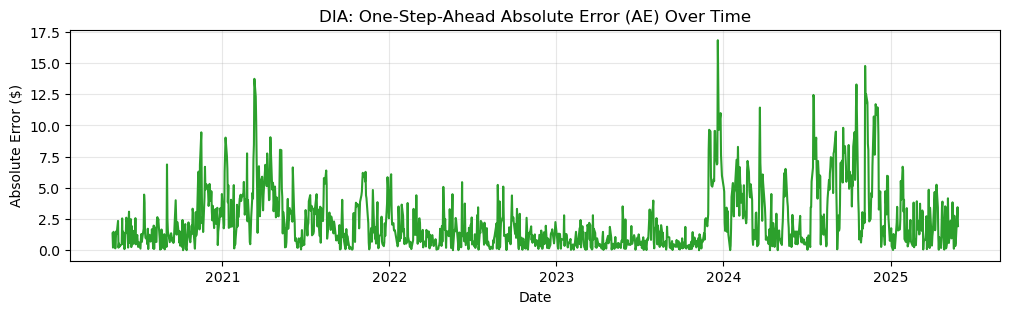

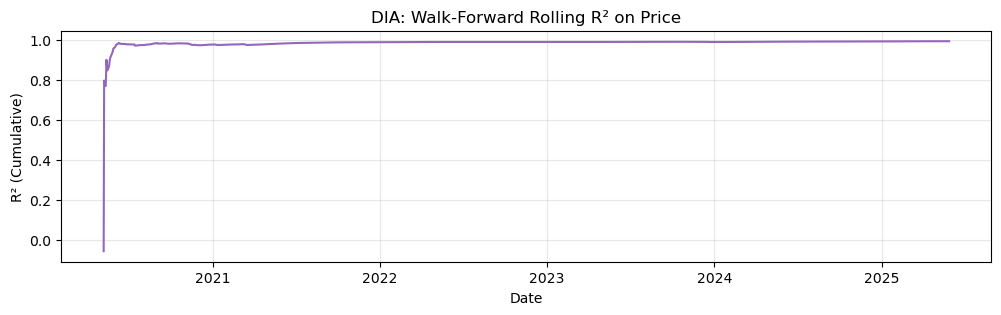

In [38]:
# XGBoost Model (Walk-Forward Retraining & Manual Hyperparameter Tuning)

# Features to use
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'EMA_3', 'EMA_5', 'RSI', 'MACD_Histogram', 'TSI', 'VIX']

# List of tickers to process
tickers = ['SPY', 'QQQ', 'DIA']

# Manual hyperparameter tuning configurations
param_grid = [
    {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 5, 'gamma': 1},
    {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_lambda': 3, 'gamma': 0.5},
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 10, 'gamma': 2}
]

for ticker in tickers:
    print(f"\n\n=== TICKER: {ticker} ===")

    # ────────────────────────────────────────────────────────
    # (A) PREPARE THE DATAFRAME FOR NEXT‐DAY “CLOSE” FORECASTING
    # ────────────────────────────────────────────────────────

    # 1) Grab the flattened DataFrame for this ticker
    df = data[ticker].copy()   # assume already flattened

    # 2) Create the next‐day‐close target: TargetClose[t] = Close[t+1]
    df['TargetClose'] = df['Close'].shift(-1)

    # 3)_DROP rows where TargetClose is NaN (i.e. the final row)
    df = df.dropna(subset=['TargetClose']).copy()

    # 4) Extract arrays for walk‐forward
    X_all   = df[features].values        # shape = (N, n_features)
    y_all   = df['TargetClose'].values    # shape = (N,)
    dates   = df.index                    # DatetimeIndex length = N

    # 5) Compute initial‐train size (80% of rows)
    N = len(df)
    initial_train_size = int(0.8 * N)
    print(f"Total days: {N:,}   |   Initial train size: {initial_train_size:,}")

    # 6) Prepare placeholders for forecasts and actual closes
    pred_close_walk   = pd.Series(data=np.nan, index=dates)   # predicted Close[t] (forecast of t+1)
    actual_close_walk = df['Close'].copy()                    # actual Close[t]

    # We will store one‐step‐ahead errors (AE, SE, APE, R²) in lists
    ae_list   = []   # absolute error = |y_true - y_pred|
    se_list   = []   # squared error  = (y_true - y_pred)^2
    ape_list  = []   # absolute percentage error = |y_true - y_pred| / |y_true|
    r2_list   = []   # rolling R² (cumulative)
    date_list = []

    # ────────────────────────────────────────────────────────
    # (B) HYPERPARAMETER TUNING ON INITIAL TRAINING DATA
    # ────────────────────────────────────────────────────────

    # Use the initial training data for tuning
    train_idx = np.arange(initial_train_size)
    X_train = X_all[train_idx, :]
    y_train = y_all[train_idx]
    
    # Split training data into train and validation sets (80-20 split of training data)
    val_split = int(0.8 * initial_train_size)
    X_train_split = X_train[:val_split, :]
    y_train_split = y_train[:val_split]
    X_val = X_train[val_split:, :]
    y_val = y_train[val_split:]
    
    # Scale features for tuning
    scaler = MinMaxScaler()
    X_train_split_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val)
    
    best_val_mse = float('inf')
    best_params = None
    best_model = None
    
    for params in param_grid:
        print(f"Trying params: {params}")
        model = XGBRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            reg_lambda=params['reg_lambda'],
            gamma=params['gamma'],
            objective='reg:squarederror',
            random_state=42,
            verbosity=0
        )
        model.fit(X_train_split_scaled, y_train_split)
        y_val_pred = model.predict(X_val_scaled)
        val_mse = mean_squared_error(y_val, y_val_pred)
        print(f"Validation MSE: {val_mse:.6f}")
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_params = params
            best_model = model
    
    print(f"Best hyperparameters for {ticker}: {best_params}")
    
    # ────────────────────────────────────────────────────────
    # (C) WALK‐FORWARD LOOP (EXPANDING WINDOW) WITH BEST MODEL
    # ────────────────────────────────────────────────────────

    for day_idx in range(initial_train_size, N):
        # (C.1) Extract train‐block [0 … day_idx-1] and test‐point = day_idx
        train_idx = np.arange(day_idx)       # [0, 1, …, day_idx-1]
        test_idx  = day_idx                  # single integer

        X_train = X_all[train_idx, :]        # features rows 0…day_idx-1
        y_train = y_all[train_idx]           # targets rows 0…day_idx-1

        X_test  = X_all[test_idx:test_idx+1, :]
        # shape = (1, n_features): features of row “day_idx” (to predict Close at day_idx+1)

        # (C.2) Scale features (fit on train, transform test)
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # (C.3) Train best XGBoost model
        model = XGBRegressor(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            reg_lambda=best_params['reg_lambda'],
            gamma=best_params['gamma'],
            objective='reg:squarederror',
            random_state=42,
            verbosity=0
        )
        model.fit(X_train_scaled, y_train)

        # (C.4) One‐step‐ahead forecast: predict Close for next day
        y_pred_next_close = model.predict(X_test_scaled)[0]
        pred_close_walk.iloc[day_idx] = y_pred_next_close

        # (Cimaginary number) Record errors for this “held‐out day_idx” 
        actual_c = actual_close_walk.iloc[day_idx]
        ae_day   = abs(actual_c - y_pred_next_close)                   # absolute error
        se_day   = (actual_c - y_pred_next_close) ** 2                  # squared error
        ape_day  = ae_day / abs(actual_c) * 100 if actual_c != 0 else np.nan

        ae_list.append(ae_day)
        se_list.append(se_day)
        ape_list.append(ape_day)
        date_list.append(dates[day_idx])

        # (C.6) Compute rolling R² over all forecasts so far
        if len(ae_list) > 1:
            y_true_so_far = actual_close_walk.loc[date_list]
            y_pred_so_far = pred_close_walk.loc[date_list]
            r2_so_far     = r2_score(y_true_so_far, y_pred_so_far)
        else:
            r2_so_far = np.nan
        r2_list.append(r2_so_far)

        # Print progress every 100 walk-forward days
        if (day_idx - initial_train_size) % 100 == 0:
            print(
                f"Trained through {dates[day_idx-1].date()}, "
                f"forecasted {dates[day_idx].date()}, "
                f"AE={ae_day:.2f}, SE={se_day:.2f}, APE={ape_day:.2f}%, "
                f"R²_so_far={r2_so_far:.4f}"
            )

    # ────────────────────────────────────────────────────────
    # (D) AGGREGATE & PRINT SUMMARY STATISTICS FOR THIS TICKER
    # ────────────────────────────────────────────────────────

    # Build a small DataFrame of the walk‐forward errors
    errors_df = pd.DataFrame({
        'Date'    : date_list,
        'AE'      : ae_list,
        'SE'      : se_list,
        'APE'     : ape_list,
        'R2_so_far': r2_list
    }).set_index('Date')

    # Compute overall metrics:
    mean_mae   = np.mean(errors_df['AE'])
    mean_mse   = np.mean(errors_df['SE'])
    mean_rmse  = np.sqrt(mean_mse)
    mean_mape  = np.mean(errors_df['APE'])
    final_r2   = errors_df['R2_so_far'].iloc[-1]  # last cumulative R²

    print(f"\n>>> {ticker} WALK‐FORWARD SUMMARY <<<")
    print(f"One‐step‐ahead MAE:    {mean_mae:.4f}")
    print(f"One‐step‐ahead MSE:    {mean_mse:.4f}")
    print(f"One‐step‐ahead RMSE:   {mean_rmse:.4f}")
    print(f"One‐step‐ahead MAPE:   {mean_mape:.2f}%")
    print(f"One‐step‐ahead R²:     {final_r2:.4f}\n")

    # Record Metrics into CSV
    pearson_corr = "NA"  # XGBoost has no Pearson
    with open(METRICS_FILE, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            ticker, "XGBoost",
            f"{mean_mae:.4f}",
            f"{mean_mse:.4f}",
            f"{mean_rmse:.4f}",
            f"{mean_mape:.2f}",
            f"{final_r2:.4f}",
            pearson_corr
        ])

    # 1) Plot actual vs. predicted close (walk‐forward)
    plt.figure(figsize=(12,5))
    plt.plot(
        actual_close_walk.index,
        actual_close_walk.values,
        label=f"{ticker} Actual Close",
        color='tab:blue'
    )
    plt.plot(
        pred_close_walk.index,
        pred_close_walk.values,
        label=f"{ticker} Walk‐Forward Predicted Close",
        color='tab:red',
        alpha=0.7
    )
    plt.axvline(
        x=dates[initial_train_size],
        color='gray',
        linestyle='--',
        label="Start of Walk‐Forward Test"
    )
    plt.title(f"{ticker}: Actual vs. Walk‐Forward One‐Step‐Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Plot day‐by‐day AE (MAE) over time
    plt.figure(figsize=(12,3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One‐Step‐Ahead Absolute Error (AE) Over Time")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(alpha=0.3)
    plt.show()

    # 3) Plot rolling R² over time
    plt.figure(figsize=(12,3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk‐Forward Rolling R² on Price")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(alpha=0.3)
    plt.show()

# 9. Train LSTM Model



=== TICKER: SPY ===
Total days: 6,356 | Initial train size: 5,084
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Validation loss: 0.017972
Trying params: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Validation loss: 0.019639
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Validation loss: 0.013656
Best hyperparameters for SPY: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.2693e-04
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.4476e-04
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.8647e-04
Epoch 7/10
79/79 ━━

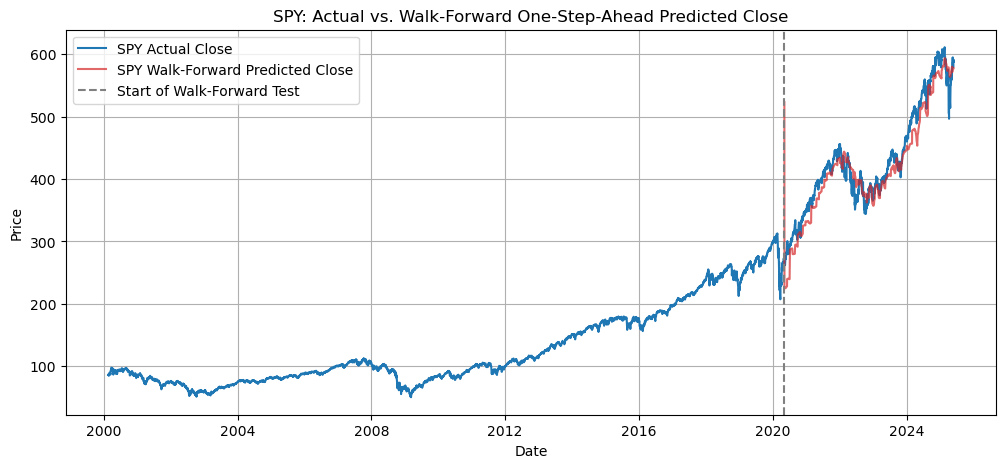

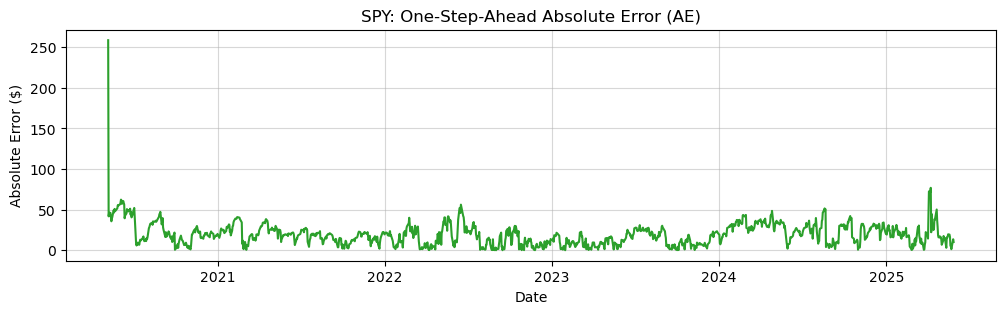

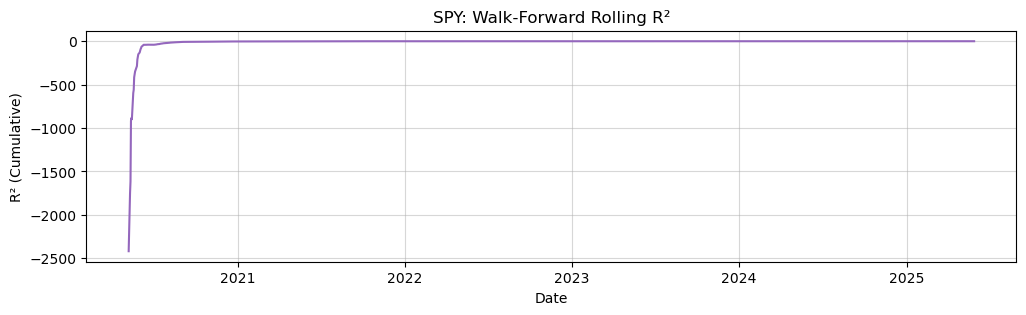



=== TICKER: QQQ ===
Total days: 6,356 | Initial train size: 5,084
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Validation loss: 0.021627
Trying params: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Validation loss: 0.011109
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Validation loss: 0.017473
Best hyperparameters for QQQ: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.5290e-04
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6103e-04
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6412e-04
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.8590e-04
Epo

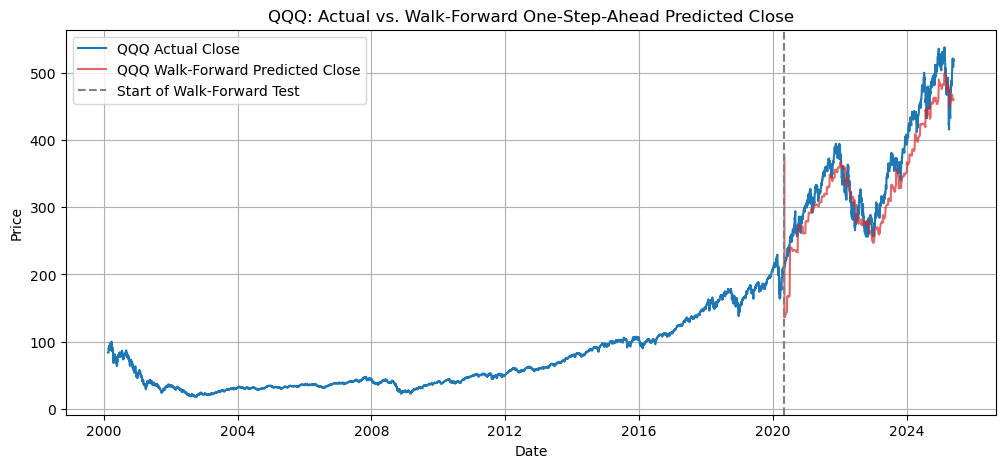

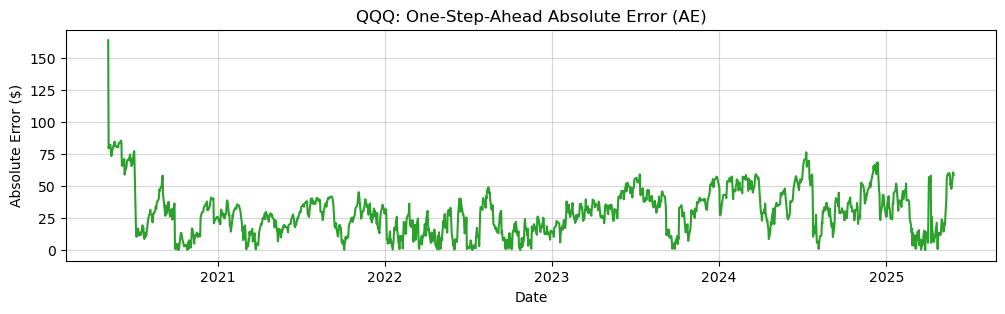

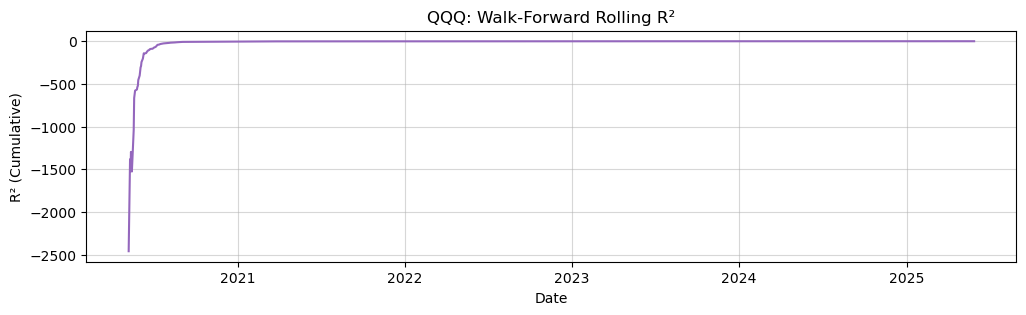



=== TICKER: DIA ===
Total days: 6,356 | Initial train size: 5,084
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Validation loss: 0.027280
Trying params: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Validation loss: 0.013554
Trying params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Validation loss: 0.019356
Best hyperparameters for DIA: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010
Epoch 7/10
158/158 

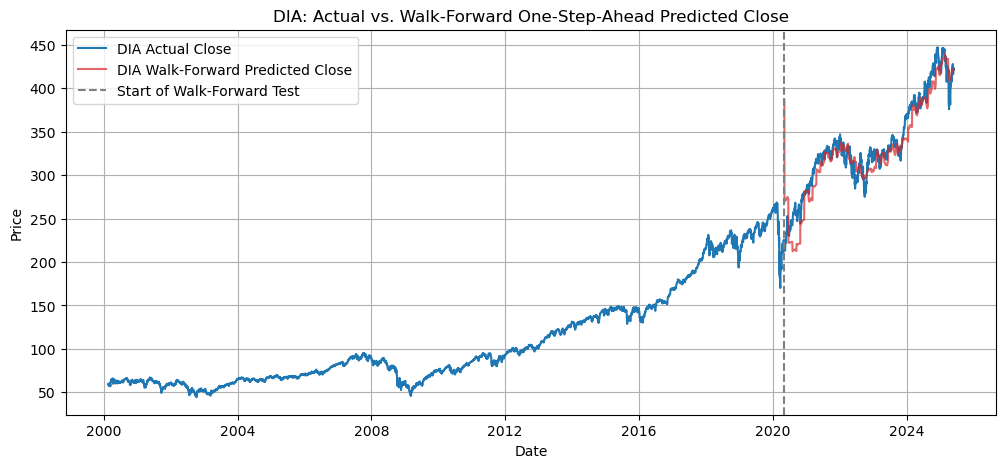

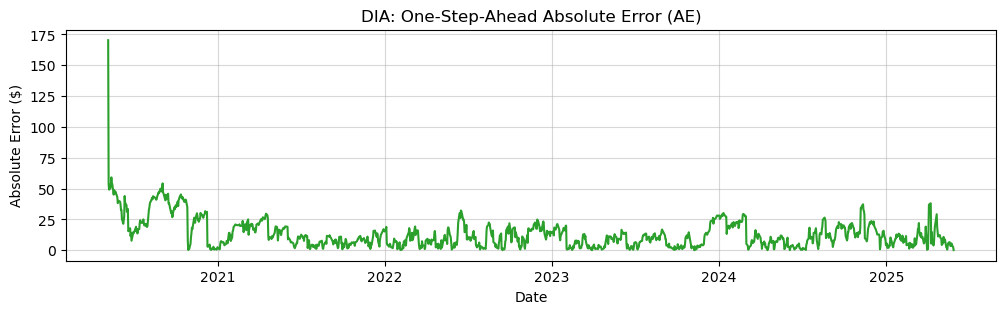

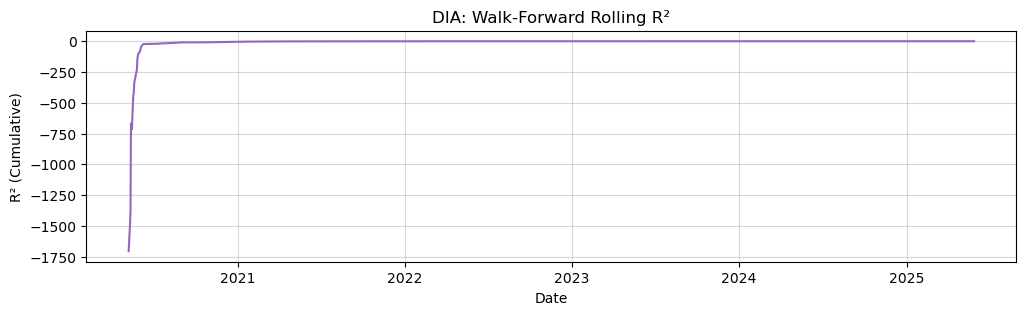

In [39]:
# LSTM Model (Walk-Forward Dynamic Retraining & Manual Hyperparameter Tuning)

# Features to use
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'EMA_3', 'EMA_5', 'RSI', 'MACD_Histogram', 'TSI', 'VIX']

# LSTM settings
timesteps = 30
train_frac = 0.8
epochs = 10

# Build LSTM model
def build_lstm_model(units_1, units_2, dropout, learning_rate):
    model = Sequential([
        LSTM(units_1, input_shape=(timesteps, len(features)), return_sequences=True),
        Dropout(dropout),
        LSTM(units_2),
        Dropout(dropout),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mse')
    return model

# Manual hyperparameter tuning configurations
param_grid = [
    {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32},
    {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32},
    {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
]

for ticker in ['SPY', 'QQQ', 'DIA']:
    print(f"\n\n=== TICKER: {ticker} ===")

    # Check for missing values
    if data[ticker][features].isna().any().any():
        print(f"Warning: Missing values in {ticker}: {data[ticker][features].isna().sum()}")
        data[ticker][features] = data[ticker][features].fillna(method='ffill')

    # Prepare DataFrame
    df = data[ticker].copy()
    df['TargetClose'] = df['Close'].shift(-1)
    df.dropna(subset=['TargetClose'], inplace=True)
    
    X = df[features].values
    y = df['TargetClose'].values
    dates = df.index
    N = len(df)
    split = int(train_frac * N)
    print(f"Total days: {N:,} | Initial train size: {split:,}")

    # Scale data
    feat_scaler = MinMaxScaler().fit(X[:split])
    targ_scaler = MinMaxScaler().fit(y[:split].reshape(-1,1))
    Xs = feat_scaler.transform(X)
    ys = targ_scaler.transform(y.reshape(-1,1)).ravel()
    
    # Build training sequences
    X_train_seq, y_train_seq = [], []
    for i in range(timesteps, split):
        X_train_seq.append(Xs[i-timesteps:i])
        y_train_seq.append(ys[i])
    X_train_seq = np.array(X_train_seq)
    y_train_seq = np.array(y_train_seq)
    
    # Manual hyperparameter tuning
    best_val_loss = float('inf')
    best_params = None
    best_model = None
    val_split = int(0.8 * len(X_train_seq))  # Use last 20% of training for validation
    
    for params in param_grid:
        print(f"Trying params: {params}")
        model = build_lstm_model(
            params['units_1'], params['units_2'], params['dropout'], params['learning_rate']
        )
        model.fit(
            X_train_seq[:val_split], y_train_seq[:val_split],
            epochs=5, batch_size=params['batch_size'], verbose=0,
            validation_data=(X_train_seq[val_split:], y_train_seq[val_split:])
        )
        val_loss = model.evaluate(X_train_seq[val_split:], y_train_seq[val_split:], verbose=0)
        print(f"Validation loss: {val_loss:.6f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            best_model = model
    
    print(f"Best hyperparameters for {ticker}: {best_params}")
    
    # Train best model on full training data
    best_model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=best_params['batch_size'], verbose=1)
    
    # Define grid of retraining frequencies and window sizes
    retrain_configs = [
        (20, 60), (20, 90), (20, 120),
        (30, 60), (30, 90), (30, 120)
    ]

    best_r2 = float('-inf')
    best_retrain_config = None
    best_forecast = {}

    for retrain_freq, retrain_window in retrain_configs:
        print(f"\n Testing retrain_freq={retrain_freq}, retrain_window={retrain_window}")
    
        window = deque(Xs[split - timesteps:split], maxlen=timesteps)
        preds, trues, pred_dates, ape_list, se_list = [], [], [], [], []

        for i in range(split, N):
            x_in = np.array(window).reshape(1, timesteps, X.shape[1])
            y_pred_s = best_model.predict(x_in, verbose=0)[0, 0]
            y_pred = targ_scaler.inverse_transform([[y_pred_s]])[0, 0]

            actual_c = df['Close'].iloc[i]
            preds.append(y_pred)
            trues.append(actual_c)
            pred_dates.append(dates[i])

            ae = abs(actual_c - y_pred)
            se = (actual_c - y_pred) ** 2
            ape = ae / abs(actual_c) * 100 if actual_c != 0 else 0
            ape_list.append(ape)
            se_list.append(se)

            window.append(Xs[i])

            if (i - split) % retrain_freq == 0 and i >= retrain_window:
                start_idx = i - retrain_window + timesteps
                end_idx = i
                if start_idx < end_idx:
                    X_finetune_seq, y_finetune_seq = [], []
                    for j in range(start_idx, end_idx):
                        if j - timesteps >= 0:  # safeguard
                            X_finetune_seq.append(Xs[j - timesteps:j])
                            y_finetune_seq.append(ys[j])
                    if len(X_finetune_seq) > 0:
                        X_finetune_seq = np.array(X_finetune_seq)
                        y_finetune_seq = np.array(y_finetune_seq)
                        best_model.fit(X_finetune_seq, y_finetune_seq, epochs=3, batch_size=best_params['batch_size'], verbose=0)

        # Evaluate performance
        r2 = r2_score(trues, preds)
        print(f"  → R²={r2:.4f}")

        if r2 > best_r2:
            best_r2 = r2
            best_retrain_config = (retrain_freq, retrain_window)
            best_forecast = {
                'preds': preds,
                'trues': trues,
                'dates': pred_dates,
                'ae': [abs(t - p) for t, p in zip(trues, preds)],
                'se': se_list,
                'ape': ape_list
            }

    # Print best config and reuse for plotting
    print(f"\n Best retrain config: freq={best_retrain_config[0]}, window={best_retrain_config[1]} | R²={best_r2:.4f}")

    # Compute metrics using best forecast
    mae = mean_absolute_error(best_forecast['trues'], best_forecast['preds'])
    mse = mean_squared_error(best_forecast['trues'], best_forecast['preds'])
    rmse = np.sqrt(mse)
    mape = np.nanmean(best_forecast['ape'])
    r2 = r2_score(best_forecast['trues'], best_forecast['preds'])
    pearson_corr, _ = pearsonr(best_forecast['trues'], best_forecast['preds'])

    print(f"\n>>> {ticker} WALK-FORWARD TEST SUMMARY <<<")
    print(f"One-step-ahead MAE:    {mae:.2f}")
    print(f"One-step-ahead MSE:    {mse:.2f}")
    print(f"One-step-ahead RMSE:   {rmse:.2f}")
    print(f"One-step-ahead MAPE:   {mape:.2f}%")
    print(f"One-step-ahead R²:     {r2:.4f}")
    print(f"One-step-ahead Pearson: {pearson_corr:.2f}\n")

    # Record Metrics into CSV
    with open(METRICS_FILE, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            ticker, "LSTM",
            f"{mae:.4f}",
            f"{mse:.4f}",
            f"{rmse:.4f}",
            f"{mape:.2f}",
            f"{r2:.4f}",
            f"{pearson_corr:.4f}"
        ])

    # Create error DataFrame
    errors_df = pd.DataFrame({
        'Date': best_forecast['dates'],
        'AE': best_forecast['ae'],
        'SE': best_forecast['se'],
        'APE': best_forecast['ape'],
        'R2_so_far': [r2_score(best_forecast['trues'][:i+1], best_forecast['preds'][:i+1]) if i > 1 else np.nan for i in range(len(best_forecast['preds']))]
    }).set_index('Date')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df['Close'], label=f"{ticker} Actual Close", color='tab:blue')
    plt.plot(best_forecast['dates'], best_forecast['preds'], label=f"{ticker} Walk-Forward Predicted Close", color='tab:red', alpha=0.7)
    plt.axvline(dates[split], color='gray', linestyle='--', label='Start of Walk-Forward Test')
    plt.title(f"{ticker}: Actual vs. Walk-Forward One-Step-Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot AE
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One-Step-Ahead Absolute Error (AE)")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(True, alpha=0.5)
    plt.show()

    # Plot rolling R²
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk-Forward Rolling R²")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(True, alpha=0.5)
    plt.show()

# 10. Train GRU Model



=== TICKER: SPY ===
Total days: 6356, train up to index 5084
 Tuning: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
 Tuning: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
 Tuning: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
 Best GRU params: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.001

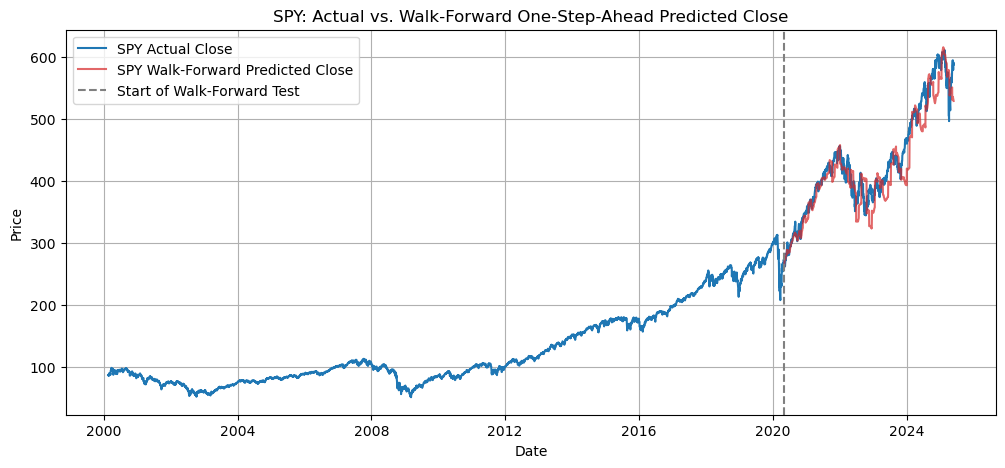

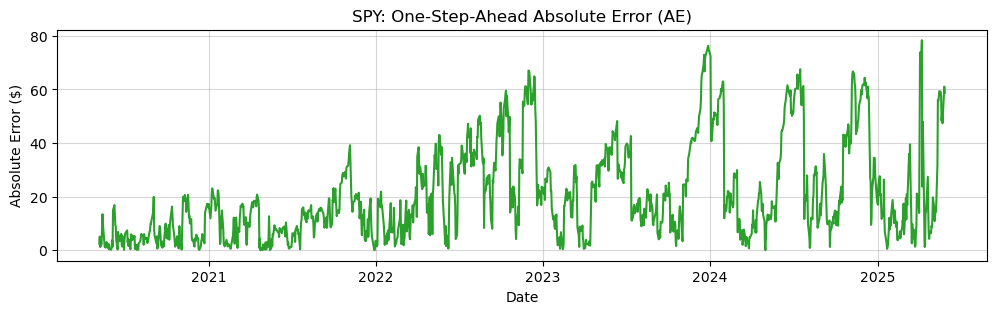

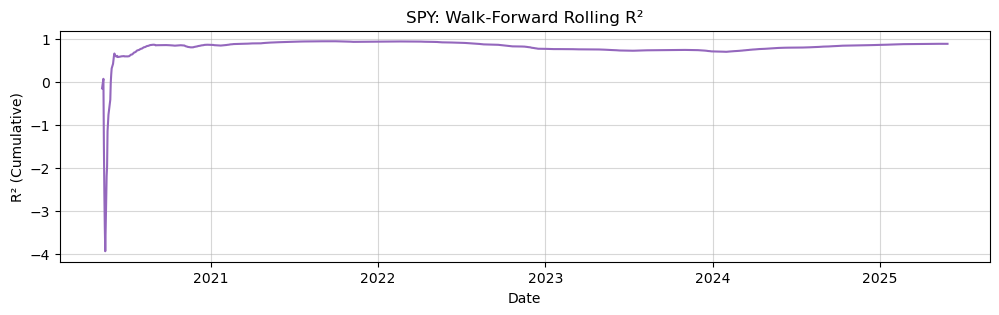



=== TICKER: QQQ ===
Total days: 6356, train up to index 5084
 Tuning: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
 Tuning: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
 Tuning: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
 Best GRU params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.9120e-04
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.0334e-04
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.8797e-04
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.1557e-04
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.

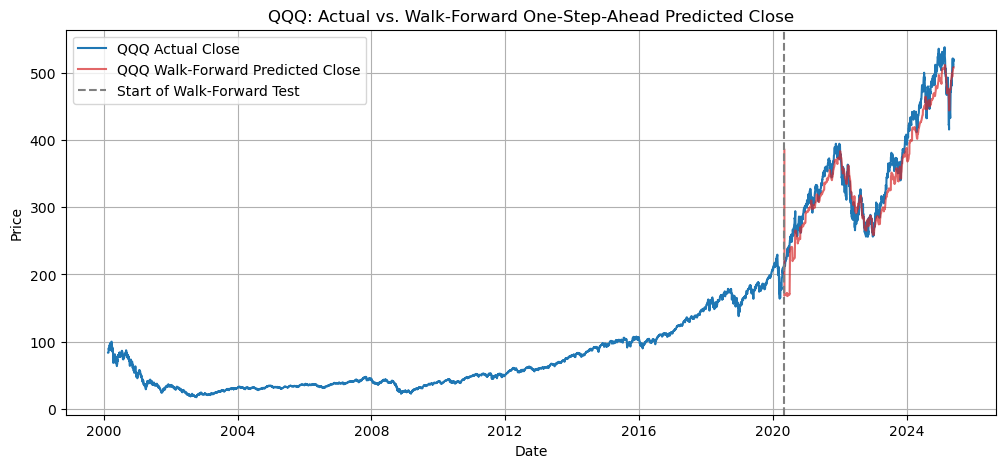

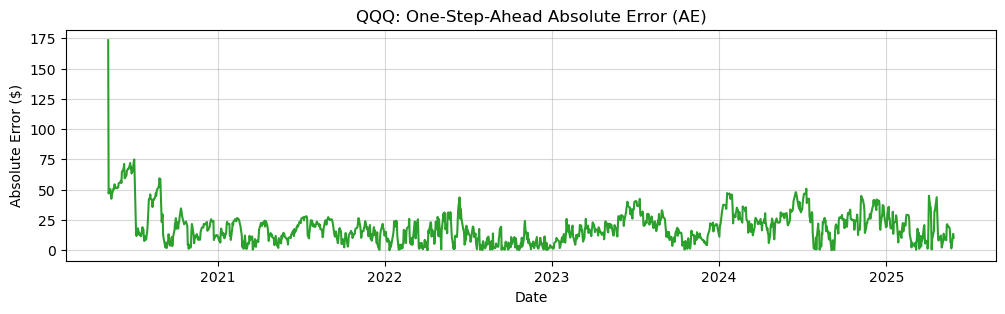

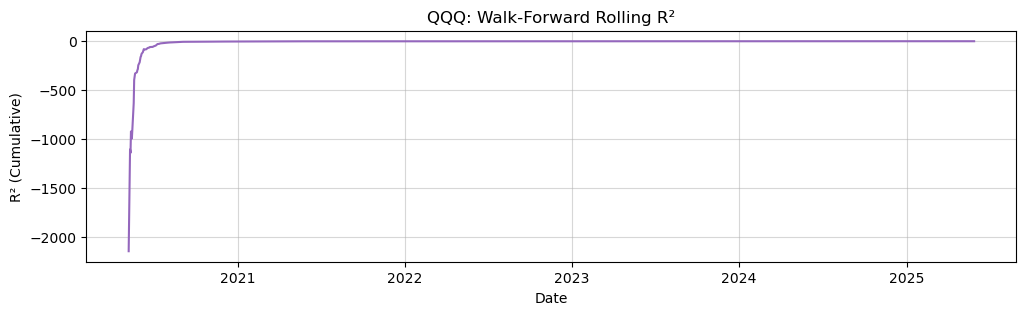



=== TICKER: DIA ===
Total days: 6356, train up to index 5084
 Tuning: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
 Tuning: {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32}
 Tuning: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
 Best GRU params: {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.8805e-04
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.2459e-04
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.3321e-04
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - 

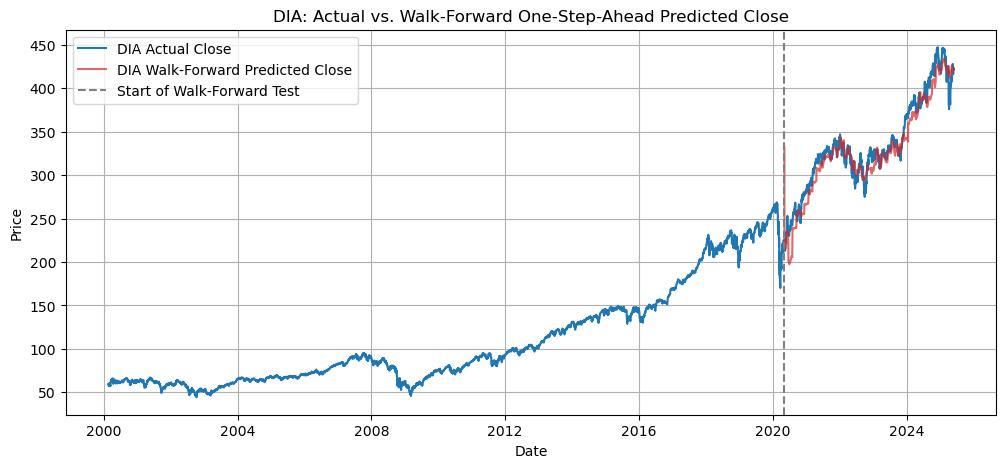

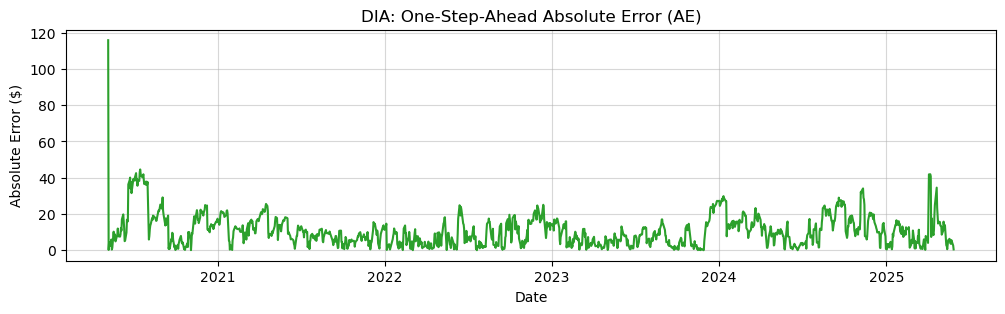

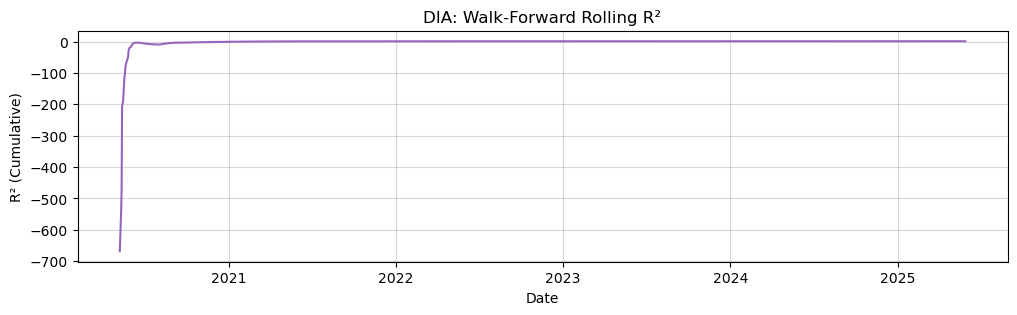

In [40]:
# GRU Model (Walk-Forward Dynamic Retraining & Manual Hyperparameter Tuning)

# Features to use
features = ['Close', 'Open', 'High', 'Low', 'Volume',
            'EMA_3', 'EMA_5', 'RSI', 'MACD_Histogram', 'TSI', 'VIX']

# GRU settings
timesteps   = 30
train_frac  = 0.8
epochs      = 10

# Build GRU model
def build_gru_model(units_1, units_2, dropout, learning_rate):
    model = Sequential([
        GRU(units_1, input_shape=(timesteps, len(features)), return_sequences=True),
        Dropout(dropout),
        GRU(units_2),
        Dropout(dropout),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mse')
    return model

# Manual hyperparameter tuning configurations
param_grid = [
    {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32},
    {'units_1': 96, 'units_2': 48, 'dropout': 0.3, 'learning_rate': 0.0005, 'batch_size': 32},
    {'units_1': 64, 'units_2': 32, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
]

# Grid of (retrain_freq, retrain_window) to test
retrain_configs = [
    (20, 60), (20, 90), (20, 120),
    (30, 60), (30, 90), (30, 120)
]

for ticker in ['SPY','QQQ','DIA']:
    print(f"\n\n=== TICKER: {ticker} ===")
    # 1) Missing values check
    if data[ticker][features].isna().any().any():
        data[ticker][features].fillna(method='ffill', inplace=True)

    # 2) Prepare data
    df = data[ticker].copy()
    df['TargetClose'] = df['Close'].shift(-1)
    df.dropna(subset=['TargetClose'], inplace=True)

    X = df[features].values
    y = df['TargetClose'].values
    dates = df.index
    N = len(df)
    split = int(train_frac * N)
    print(f"Total days: {N}, train up to index {split}")

    # 3) Scale & sequence build
    feat_scaler = MinMaxScaler().fit(X[:split])
    targ_scaler = MinMaxScaler().fit(y[:split].reshape(-1,1))
    Xs = feat_scaler.transform(X)
    ys = targ_scaler.transform(y.reshape(-1,1)).ravel()

    X_train_seq, y_train_seq = [], []
    for i in range(timesteps, split):
        X_train_seq.append(Xs[i-timesteps:i])
        y_train_seq.append(ys[i])
    X_train_seq = np.array(X_train_seq)
    y_train_seq = np.array(y_train_seq)

    # 4) Hyperparameter tuning
    best_val_loss = float('inf')
    best_params   = None
    best_model    = None
    val_split     = int(0.8 * len(X_train_seq))

    for params in param_grid:
        print(f" Tuning: {params}")
        model = build_gru_model(params['units_1'], params['units_2'],
                                params['dropout'], params['learning_rate'])
        model.fit(X_train_seq[:val_split], y_train_seq[:val_split],
                  epochs=5, batch_size=params['batch_size'], verbose=0,
                  validation_data=(X_train_seq[val_split:], y_train_seq[val_split:]))
        val_loss = model.evaluate(X_train_seq[val_split:], y_train_seq[val_split:], verbose=0)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params   = params
            best_model    = model

    print(f" Best GRU params: {best_params}")

    # 5) Train on full training block
    best_model.fit(X_train_seq, y_train_seq,
                   epochs=epochs, batch_size=best_params['batch_size'], verbose=1)

    # 6) Walk-forward with grid search over retrain configs
    best_r2             = float('-inf')
    best_retrain_config = None
    best_forecast       = {}

    for retrain_freq, retrain_window in retrain_configs:
        print(f"\n Testing retrain_freq={retrain_freq}, retrain_window={retrain_window}")
        window = deque(Xs[split-timesteps:split], maxlen=timesteps)
        preds, trues, pred_dates, ape_list, se_list = [], [], [], [], []

        for i in range(split, N):
            # predict
            x_in = np.array(window).reshape(1, timesteps, X.shape[1])
            y_pred_s = best_model.predict(x_in, verbose=0)[0,0]
            y_pred   = targ_scaler.inverse_transform([[y_pred_s]])[0,0]

            actual_c = df['Close'].iloc[i]
            preds.append(y_pred); trues.append(actual_c); pred_dates.append(dates[i])
            ae = abs(actual_c-y_pred); se = ae**2
            ape_list.append(ae/abs(actual_c)*100 if actual_c else 0)
            se_list.append(se)
            window.append(Xs[i])

            # periodic fine-tune
            if (i-split) % retrain_freq == 0 and i >= retrain_window:
                start_idx = i - retrain_window + timesteps
                if start_idx < i:
                    X_ft, y_ft = [], []
                    for j in range(start_idx, i):
                        X_ft.append(Xs[j-timesteps:j])
                        y_ft.append(ys[j])
                    if X_ft:
                        X_ft = np.array(X_ft)
                        y_ft = np.array(y_ft)
                        best_model.fit(X_ft, y_ft,
                                       epochs=3,
                                       batch_size=best_params['batch_size'],
                                       verbose=0)

        # evaluate this config
        r2 = r2_score(trues, preds)
        print(f"  → R²={r2:.4f}")
        if r2 > best_r2:
            best_r2             = r2
            best_retrain_config = (retrain_freq, retrain_window)
            best_forecast       = {
                'preds': preds,
                'trues': trues,
                'dates': pred_dates,
                'ae':    [abs(t-p) for t,p in zip(trues,preds)],
                'se':    se_list,
                'ape':   ape_list
            }

    print(f"\n Best retrain config: freq={best_retrain_config[0]}, window={best_retrain_config[1]} | R²={best_r2:.4f}")

    # 7) Metrics & plots using best_forecast
    mae = mean_absolute_error(best_forecast['trues'], best_forecast['preds'])
    mse = mean_squared_error(best_forecast['trues'], best_forecast['preds'])
    rmse = np.sqrt(mse)
    mape = np.nanmean(best_forecast['ape'])
    r2   = r2_score(best_forecast['trues'], best_forecast['preds'])
    pcorr,_ = pearsonr(best_forecast['trues'], best_forecast['preds'])

    print(f"\n>>> {ticker} WALK-FORWARD TEST SUMMARY <<<")
    print(f"One-step-ahead MAE:    {mae:.2f}")
    print(f"One-step-ahead MSE:    {mse:.2f}")
    print(f"One-step-ahead RMSE:   {rmse:.2f}")
    print(f"One-step-ahead MAPE:   {mape:.2f}%")
    print(f"One-step-ahead R²:     {r2:.4f}")
    print(f"One-step-ahead Pearson: {pcorr:.2f}\n")

    # Record Metrics into CSV
    with open(METRICS_FILE, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            ticker, "GRU",
            f"{mae:.4f}",
            f"{mse:.4f}",
            f"{rmse:.4f}",
            f"{mape:.2f}",
            f"{r2:.4f}",
            f"{pcorr:.4f}"
        ])


    # Create error DataFrame
    errors_df = pd.DataFrame({
        'Date': best_forecast['dates'],
        'AE': best_forecast['ae'],
        'SE': best_forecast['se'],
        'APE': best_forecast['ape'],
        'R2_so_far': [r2_score(best_forecast['trues'][:i+1], best_forecast['preds'][:i+1]) if i > 1 else np.nan for i in range(len(best_forecast['preds']))]
    }).set_index('Date')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df['Close'], label=f"{ticker} Actual Close", color='tab:blue')
    plt.plot(best_forecast['dates'], best_forecast['preds'], label=f"{ticker} Walk-Forward Predicted Close", color='tab:red', alpha=0.7)
    plt.axvline(dates[split], color='gray', linestyle='--', label='Start of Walk-Forward Test')
    plt.title(f"{ticker}: Actual vs. Walk-Forward One-Step-Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot AE
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One-Step-Ahead Absolute Error (AE)")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(True, alpha=0.5)
    plt.show()

    # Plot rolling R²
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk-Forward Rolling R²")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(True, alpha=0.5)
    plt.show()

# 11. Compare Model Metrics

In [41]:
df_metrics = pd.read_csv("model_metrics.csv")
# sort rows first by ticker, then by model
df_metrics = df_metrics.sort_values(['ticker','model'])
df_metrics

ticker    model      MAE        MSE     RMSE  MAPE      R2  Pearson
8    DIA      GRU  10.6991   192.0928  13.8598  3.32  0.9287   0.9745
5    DIA     LSTM  13.0509   308.4554  17.5629  4.23  0.8855   0.9539
2    DIA  XGBoost   2.3234    11.3130   3.3635  0.68  0.9958      NaN
7    QQQ      GRU  18.8578   547.1809  23.3919  5.50  0.9152   0.9725
4    QQQ     LSTM  29.2206  1171.8847  34.2328  8.33  0.8184   0.9582
1    QQQ  XGBoost   3.8897    31.0477   5.5720  1.08  0.9952      NaN
6    SPY      GRU  20.6354   733.5205  27.0836  4.69  0.8944   0.9545
3    SPY     LSTM  19.3675   576.8409  24.0175  4.71  0.9169   0.9694
0    SPY  XGBoost   3.6862    25.7847   5.0779  0.84  0.9963      NaN